# Часть 1

## Этап 1

Импорты

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import plotly.express as px

from scipy.stats import chi2_contingency
from statsmodels.stats.proportion import proportions_ztest

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
import optuna
from optuna import Trial, create_study
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
)

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.preprocessing import PolynomialFeatures
from lightgbm import LGBMClassifier, LGBMRegressor
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier, XGBRegressor
from causalml.inference.meta import BaseTClassifier, BaseSClassifier,BaseXClassifier, BaseRClassifier, BaseRRegressor


from sklift.viz import plot_qini_curve, plot_uplift_curve
from utils import custom_uplift_by_percentile

from sklift.metrics import uplift_auc_score, qini_auc_score, uplift_at_k

import warnings
warnings.filterwarnings("ignore")


pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')

import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature


from dotenv import load_dotenv
import os
import boto3


In [3]:
df = pd.read_csv(r"/home/mle-user/mle_projects/uplift_modelLing_food_app/uplift_fp_data.csv")

In [4]:
df.head(5)

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,treatment,target
0,10,1,142.44,1,0,1,0,1,1,0
1,6,2,329.08,1,1,2,1,2,0,0
2,7,1,180.65,0,1,1,1,2,1,0
3,9,4,675.83,1,0,2,1,2,0,0
4,2,0,45.34,1,0,0,0,2,1,0


In [5]:
df.describe()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,treatment,target
count,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000
mean,5.763734,1.481969,242.085656,0.551031,0.549719,0.748469,0.502250,1.319609,0.334172,0.146781
std,3.507592,1.544514,256.158608,0.497393,0.497526,0.697936,0.499999,0.678254,0.471704,0.353890
min,1.000000,0.000000,29.990000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,64.660000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,6.000000,1.000000,158.110000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
75%,9.000000,2.000000,325.657500,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,0.000000
max,12.000000,6.000000,3345.930000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   recency          64000 non-null  int64  
 1   history_segment  64000 non-null  int64  
 2   history          64000 non-null  float64
 3   mens             64000 non-null  int64  
 4   womens           64000 non-null  int64  
 5   zip_code         64000 non-null  int64  
 6   newbie           64000 non-null  int64  
 7   channel          64000 non-null  int64  
 8   treatment        64000 non-null  int64  
 9   target           64000 non-null  int64  
dtypes: float64(1), int64(9)
memory usage: 4.9 MB


- recency — количество месяцев с момента последней покупки. Этот атрибут помогает понять, как долго клиент не совершал покупок (индикатором его вовлечённости).

- history_segment — категоризация расходов клиента за последний год. Этот атрибут позволяет сегментировать клиентов по уровню их трат (помощь в таргетировании предложений).

- history — фактическая сумма (в $), потраченная клиентом за последний год. Этот атрибут предоставляет информацию о финансовом поведении клиента.

- mens — индикатор (1/0), где 1 означает, что клиент покупал товары для мужчин в течение последнего года. Это помогает определить предпочтения клиента.

- womens — индикатор (1/0), где 1 означает, что клиент покупал товары для женщин в течение последнего года. Это также помогает определить предпочтения клиента.

- zip_code — классификация почтового индекса (город, пригород, село). Этот атрибут может быть полезен для географического анализа клиентов.

- newbie — индикатор (1/0), где 1 обозначает нового клиента (в течение последних двенадцати месяцев). Это поможет оценить эффективность маркетинговых стратегий для привлечения новых клиентов.

- channel — описание каналов, через которые клиент совершал покупки в течение последнего года. Этот атрибут поможет с анализом предпочтений клиентов по каналам продаж (0 — мультиканал, 1 — мобильный, 2 — веб).

- treatment — индикатор (1/0), где 1 означает, что клиент получил промокод. Этот атрибут позволяет оценить влияние предложения на поведение клиента и его решение о покупке.

- target — индикатор (1/0), где 1 означает, что клиент успешно использовал промокод.

In [7]:
df.isnull().sum()

recency            0
history_segment    0
history            0
mens               0
womens             0
zip_code           0
newbie             0
channel            0
treatment          0
target             0
dtype: int64

## Этап 2

### EDA


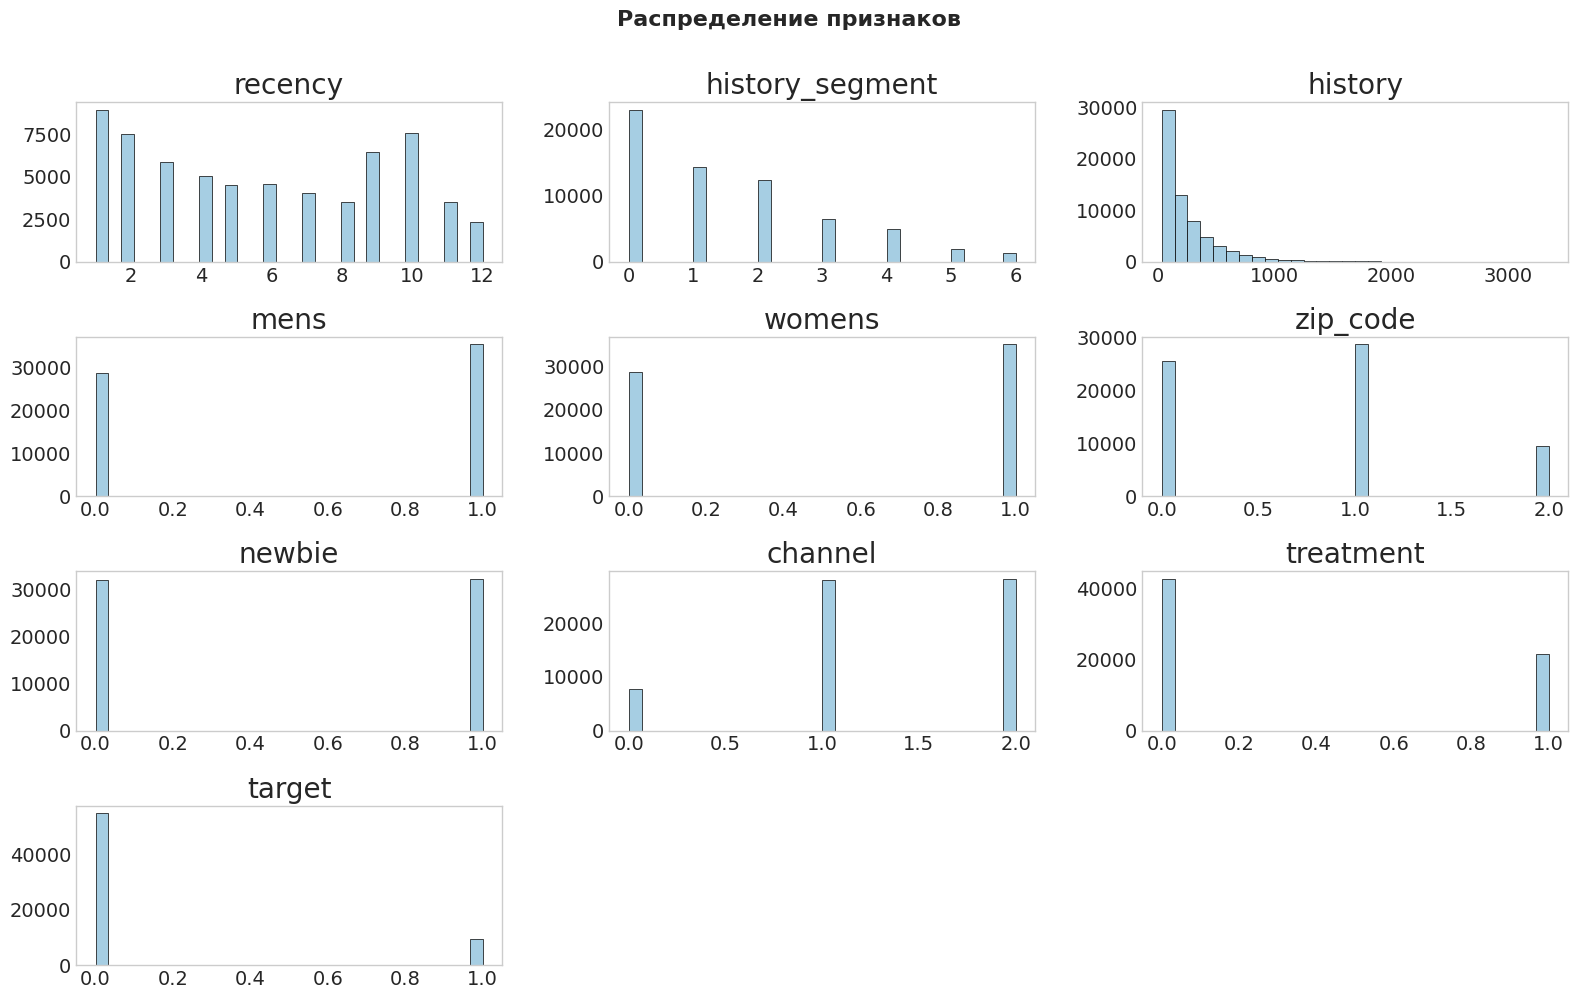

In [8]:
df.hist(figsize=(16, 10), bins=30, edgecolor='black', grid=False)
plt.suptitle('Распределение признаков', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

Понятно все, кроме history_segment и history, надо посмотреть связь между категориями сегмента и реальными суммами

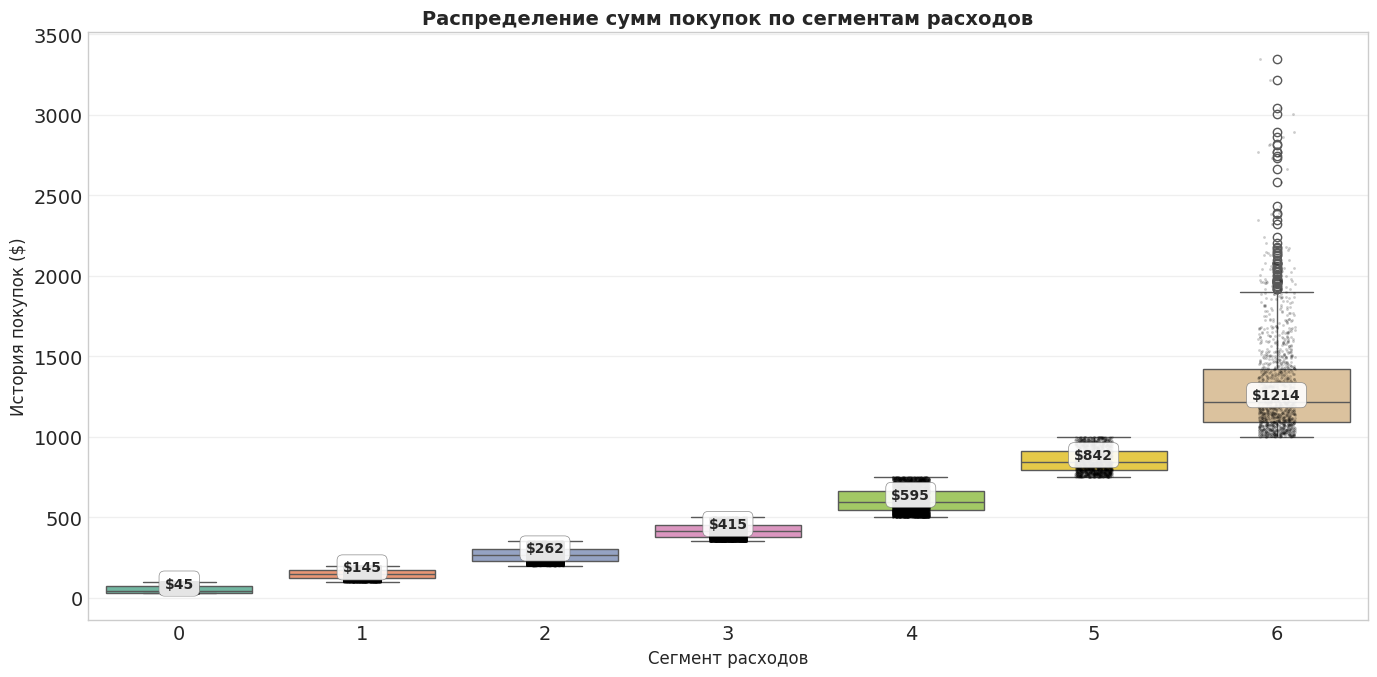

In [9]:
fig, ax = plt.subplots(figsize=(14, 7))

# Box plot с точками
sns.boxplot(data=df, x='history_segment', y='history', palette='Set2', ax=ax)
sns.stripplot(data=df, x='history_segment', y='history', 
              size=2, color='black', alpha=0.2, ax=ax)

ax.set_title('Распределение сумм покупок по сегментам расходов', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Сегмент расходов', fontsize=12)
ax.set_ylabel('История покупок ($)', fontsize=12)
ax.grid(axis='y', alpha=0.3)

# Добавляем медианы с белым фоном
medians = df.groupby('history_segment')['history'].median()
for i, median in enumerate(medians):
    ax.text(i, median, f'${median:.0f}', 
            ha='center', va='bottom', fontweight='bold', fontsize=10,
            bbox=dict(boxstyle='round,pad=0.4', facecolor='white', 
                     edgecolor='gray', alpha=0.9))

plt.tight_layout()
plt.show()

Проверим сбалансированность выборки, оценив распределение целевой переменной между контрольной и тестовой группами

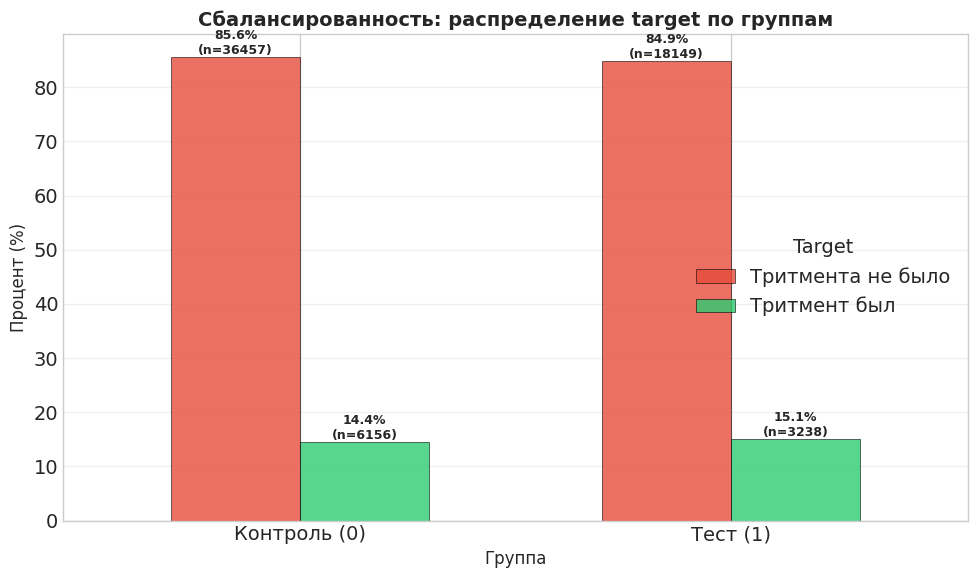


Статистика по группам:
Контроль: 14.45% (6156/42613 чел.)
Тест:     15.14% (3238/21387 чел.)
Разница:  Δ = 0.69%


In [10]:
fig, ax = plt.subplots(figsize=(10, 6))

ct = pd.crosstab(df['treatment'], df['target'], normalize='index') * 100
ct_counts = pd.crosstab(df['treatment'], df['target'])  # Абсолютные значения

ct.plot(kind='bar', ax=ax, color=['#e74c3c', '#2ecc71'], 
        edgecolor='black', alpha=0.8, width=0.6)

ax.set_title('Сбалансированность: распределение target по группам', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Группа', fontsize=12)
ax.set_ylabel('Процент (%)', fontsize=12)
ax.set_xticklabels(['Контроль (0)', 'Тест (1)'], rotation=0)
ax.legend(['Тритмента не было', 'Тритмент был'], title='Target')
ax.grid(axis='y', alpha=0.3)

# Значения над столбцами с процентами и количеством
for i, container in enumerate(ax.containers):
    labels = []
    for j, bar in enumerate(container):
        pct = ct.iloc[j, i]
        count = ct_counts.iloc[j, i]
        labels.append(f'{pct:.1f}%\n(n={count})')
    ax.bar_label(container, labels=labels, fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

# Расширенная статистика
conv = df.groupby('treatment')['target'].mean() * 100
counts = df.groupby('treatment').size()
target_counts = df.groupby('treatment')['target'].sum()

print(f"\nСтатистика по группам:")
print(f"Контроль: {conv[0]:.2f}% ({int(target_counts[0])}/{counts[0]} чел.)")
print(f"Тест:     {conv[1]:.2f}% ({int(target_counts[1])}/{counts[1]} чел.)")
print(f"Разница:  Δ = {conv[1]-conv[0]:.2f}%")

# Этап 2

### Проверка статистической значимости

In [11]:
# Chi-square test
contingency_table = pd.crosstab(df['treatment'], df['target'])
chi2, p_chi, _, _ = chi2_contingency(contingency_table)

# Z-test для пропорций (альтернатива)
count = [
    df[df['treatment']==1]['target'].sum(),
    df[df['treatment']==0]['target'].sum()
]
nobs = [
    len(df[df['treatment']==1]),
    len(df[df['treatment']==0])
]
z_stat, p_z = proportions_ztest(count, nobs)

print(f"Chi-square: χ² = {chi2:.4f}, p = {p_chi:.4f}")
print(f"Z-test:     z² = {z_stat**2:.4f}, p = {p_z:.4f}")


Chi-square: χ² = 5.4171, p = 0.0199
Z-test:     z² = 5.4724, p = 0.0193


Для оценки статистической значимости различий между группами применён критерий хи-квадрат Пирсона по следующии причинам: категориальность целевой переменной, большой размер выборки, 2 группы (контроль и тест). Полученное значение χ² = 5.42 (p = 0.0199) указывает на статистически значимую связь между получением промокода и фактом покупки на уровне значимости α = 0.05. Это подтверждается Z-тестом для сравнения пропорций.


### Проверка корреляций

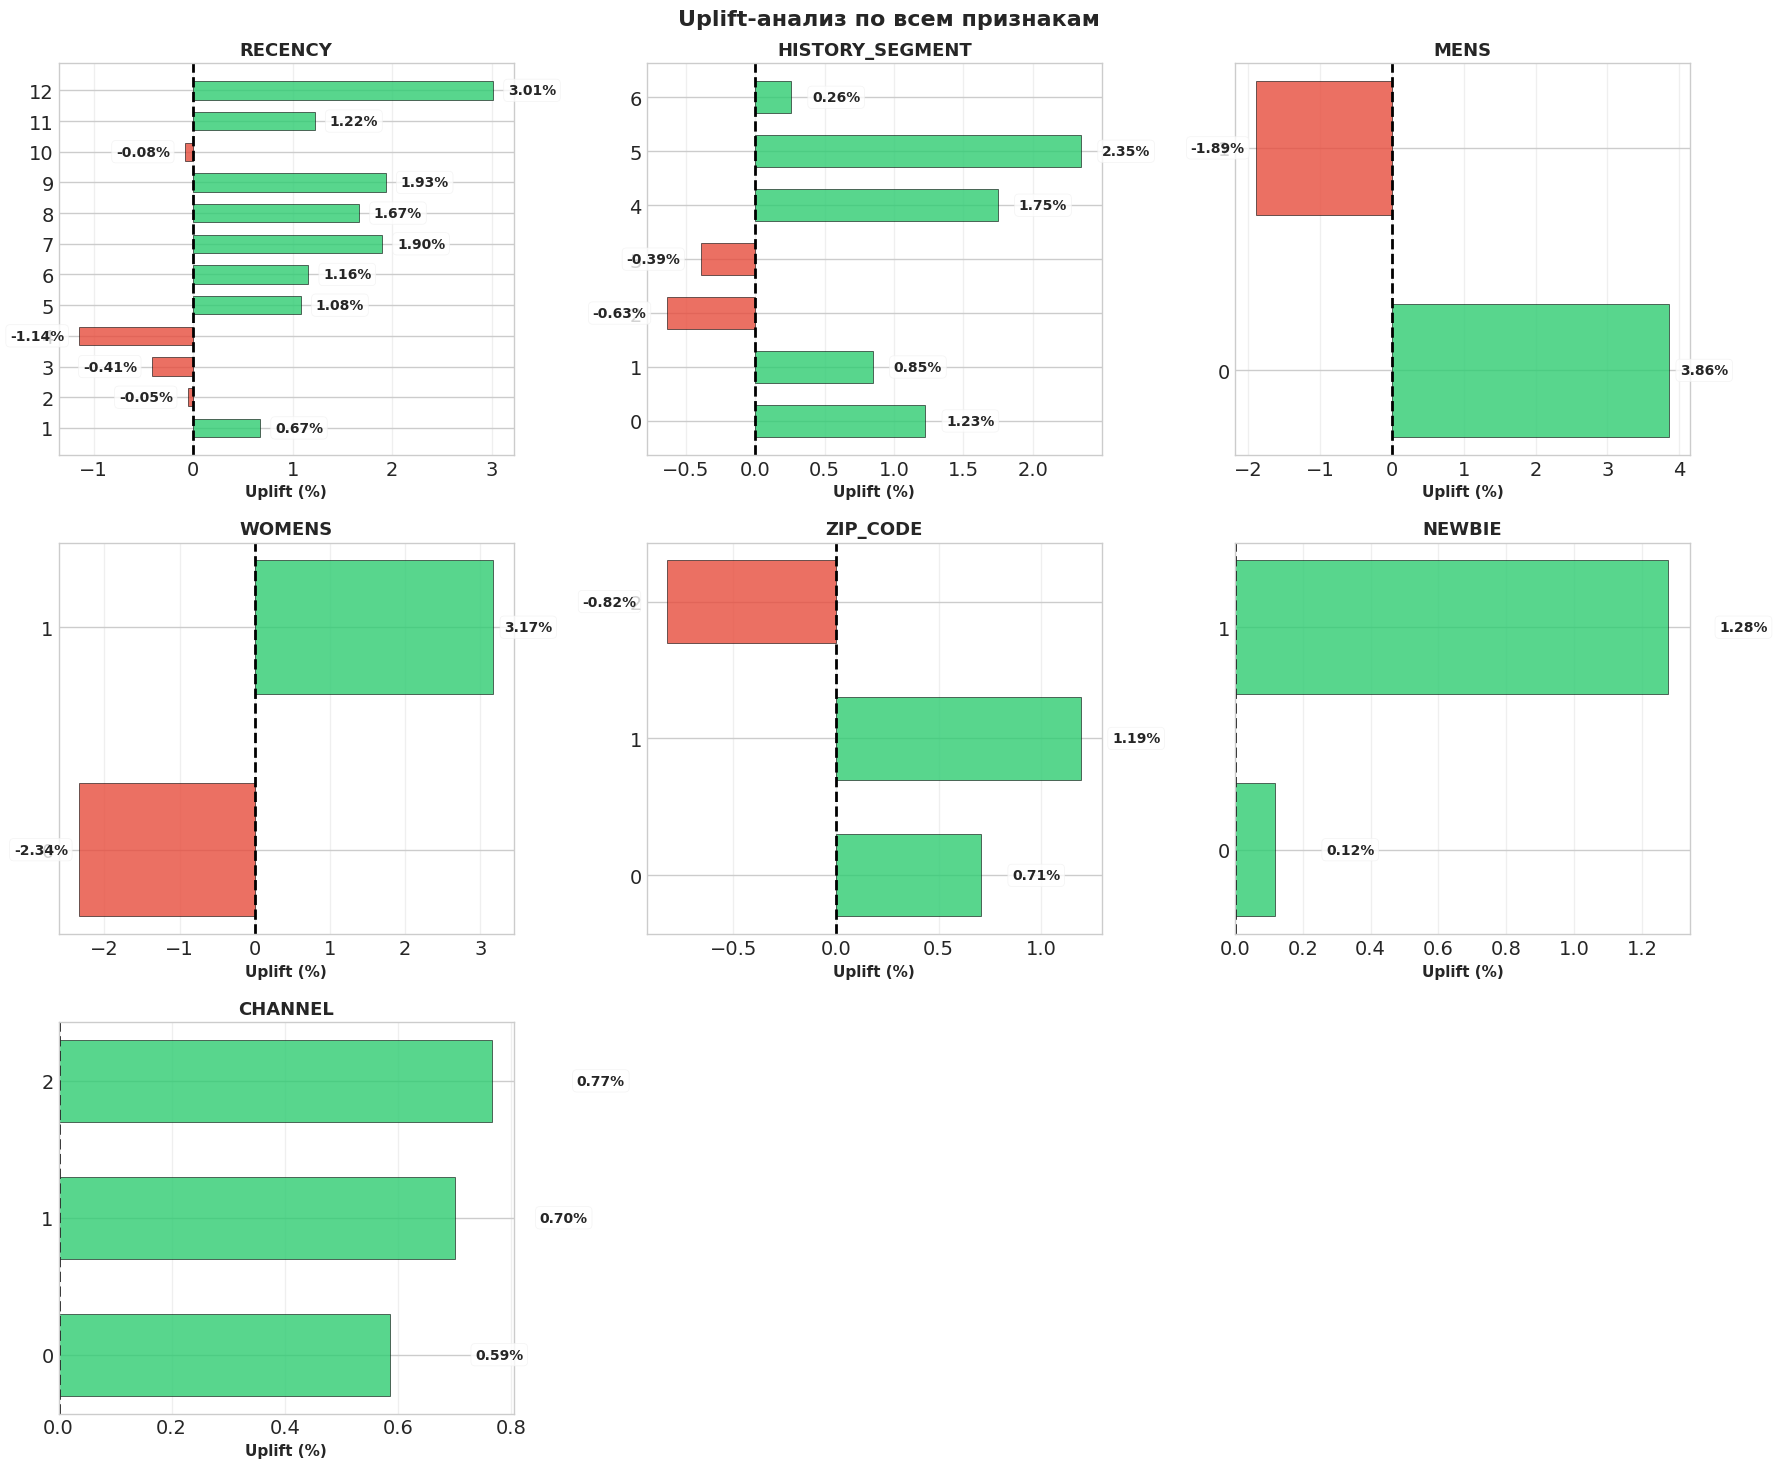

ПОЛНАЯ СТАТИСТИКА ПО ВСЕМ СЕГМЕНТАМ

RECENCY
Значение  12: Контроль=11.67% | Тест=14.68% | Uplift= +3.01%
Значение   9: Контроль=10.76% | Тест=12.70% | Uplift= +1.93%
Значение   7: Контроль=12.76% | Тест=14.65% | Uplift= +1.90%
Значение   8: Контроль=12.24% | Тест=13.90% | Uplift= +1.67%
Значение  11: Контроль=11.66% | Тест=12.88% | Uplift= +1.22%
Значение   6: Контроль=13.68% | Тест=14.84% | Uplift= +1.16%
Значение   5: Контроль=13.87% | Тест=14.95% | Uplift= +1.08%
Значение   1: Контроль=19.08% | Тест=19.75% | Uplift= +0.67%
Значение   2: Контроль=17.80% | Тест=17.74% | Uplift= -0.05%
Значение  10: Контроль=11.29% | Тест=11.21% | Uplift= -0.08%
Значение   3: Контроль=16.77% | Тест=16.36% | Uplift= -0.41%
Значение   4: Контроль=15.27% | Тест=14.12% | Uplift= -1.14%

HISTORY_SEGMENT
Значение   5: Контроль=18.56% | Тест=20.91% | Uplift= +2.35%
Значение   4: Контроль=15.82% | Тест=17.57% | Uplift= +1.75%
Значение   0: Контроль=11.94% | Тест=13.16% | Uplift= +1.23%
Значение   1: Контроль=

In [125]:
#  Только категориальные признаки
segments = ['recency', 'history_segment', 'mens', 'womens', 
            'zip_code', 'newbie', 'channel']

# Сетка
n_cols = 3
n_rows = (len(segments) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 5))
axes = axes.flatten()

# Собираем данные для таблицы
all_results = []

for idx, segment in enumerate(segments):
    ax = axes[idx]
    
    # Uplift
    pivot = df.groupby([segment, 'treatment'])['target'].mean().unstack()
    uplift = (pivot[1] - pivot[0]) * 100
    
    # Сохраняем для таблицы
    for seg_val, upl_val in uplift.items():
        all_results.append({
            'Признак': segment,
            'Значение': seg_val,
            'Контроль (%)': pivot.loc[seg_val, 0] * 100,
            'Тест (%)': pivot.loc[seg_val, 1] * 100,
            'Uplift (%)': upl_val
        })
    
    colors = ['#2ecc71' if x > 0 else '#e74c3c' for x in uplift.values]
    
    bars = ax.barh(range(len(uplift)), uplift.values, color=colors, 
                   edgecolor='black', alpha=0.8, height=0.6)
    ax.set_yticks(range(len(uplift)))
    ax.set_yticklabels(uplift.index)
    ax.set_xlabel('Uplift (%)', fontsize=11, fontweight='bold')
    ax.set_title(f'{segment.upper()}', fontsize=13, fontweight='bold')
    ax.axvline(x=0, color='black', linestyle='--', linewidth=2)
    ax.grid(axis='x', alpha=0.3)
    
    # Подписи
    for i, (bar, val) in enumerate(zip(bars, uplift.values)):
        ax.text(val + (0.15 if val > 0 else -0.15), i, 
               f'{val:.2f}%', va='center', 
               ha='left' if val > 0 else 'right',
               fontweight='bold', fontsize=10,
               bbox=dict(boxstyle='round,pad=0.3', 
                        facecolor='white', alpha=0.8))

# Скрыть лишние оси
for j in range(len(segments), len(axes)):
    axes[j].axis('off')

plt.suptitle('Uplift-анализ по всем признакам', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Текстовый вывод
results_df = pd.DataFrame(all_results)


print("ПОЛНАЯ СТАТИСТИКА ПО ВСЕМ СЕГМЕНТАМ")


for segment in segments:
    print(f"\n{'='*60}")
    print(f"{segment.upper()}")
    print(f"{'='*60}")
    
    segment_data = results_df[results_df['Признак'] == segment].sort_values('Uplift (%)', ascending=False)
    
    for _, row in segment_data.iterrows():
        
        print(f"Значение {row['Значение']:>3}: "
              f"Контроль={row['Контроль (%)']:>5.2f}% | "
              f"Тест={row['Тест (%)']:>5.2f}% | "
              f"Uplift={row['Uplift (%)']:>+6.2f}%")


print("ТОП-10 СЕГМЕНТОВ С МАКСИМАЛЬНЫМ UPLIFT")


top_segments = results_df.sort_values('Uplift (%)', ascending=False).head(10)
for i, row in enumerate(top_segments.itertuples(), 1):
    print(f"{i:2}. {row.Признак:>15} = {row.Значение:>3} | "
          f"Uplift: {row._5:>+6.2f}% | "
          f"Контроль: {row._3:>5.2f}% → Тест: {row._4:>5.2f}%")


print("ТОП-10 СЕГМЕНТОВ С МИНИМАЛЬНЫМ/НЕГАТИВНЫМ UPLIFT")


bottom_segments = results_df.sort_values('Uplift (%)').head(10)
for i, row in enumerate(bottom_segments.itertuples(), 1):
    print(f"{i:2}. {row.Признак:>15} = {row.Значение:>3} | "
          f"Uplift: {row._5:>+6.2f}% | "
          f"Контроль: {row._3:>5.2f}% → Тест: {row._4:>5.2f}%")



### Промежуточные выводы

- Результаты A/B-тест показали статистически значимую разницу между контрольной и тестовой группами (Chi-square = 5.42, p-value = 0.02). Общий прирост конверсии составил 0.69%.

- Промокоды работают совершенно по-разному для разных групп клиентов: для одних они увеличивают конверсию на 3-4%, а для других, наоборот, снижают её на 1-2%. Самый сильный положительный эффект наблюдается среди клиентов, покупающих женские товары (+3.17%), тех, кто не покупает мужские товары (+3.86%), и ушедших клиентов с давностью последней покупки 7-12 месяцев (+1.67% до +3.01%).

- Сегмент с самыми высокими затратами также хорошо реагирует на промокоды с приростом до 2.35%. Идеальный профиль для промокода - это женщина с богатой историей покупок (тратит много, 600-1000 долларов в общем), не покупавшая 7-12 месяцев.

- Для некоторых сегментов промокоды приводят к негативному эффекту. Клиенты мужского сегмента показывают падение конверсии на 1.89%, а те, кто не покупает женские товары - на 2.34% (может, не любят спам?).

- Активные клиенты, совершавшие покупки 4 месяца назад, также демонстрируют отрицательный uplift (-1.14%). МОжет, они купили бы и без скидки.

- При текущем подходе массовой рассылки промокодов положительные и отрицательные эффекты взаимно гасятся. Переход к таргетированной стратегии, при которой промокоды получают только топ-30% клиентов с максимальным прогнозируемым uplift, могут привести к увеличению увеличить ROI.

## Этап 3

В качестве базовой модели выбран T-Learner с CatBoost в качестве базового алгоритма в связи с тем, что анализ показал сильную гетерогенность эффекта: uplift варьируется от -2.34% до +3.86% в зависимости от сегмента клиента, то есть для S-Learner или аплифт-деревьев это сложно.

### Советы по обучению и инференсу моделей
1. Некоторые uplift модели из библиотеки `causalml` будут требовать категориальные значения воздействия. Для этого используйте маппинг
#### Пример использования маппинга
```python
treatment_mapping = {
    0: 'control',
    1: 'treatment'
}
treatment_train_mapped = treatment_train.map(treatment_mapping)
treatment_test_mapped = treatment_test.map(treatment_mapping)
```

2. При вызове метода `.predict` и получения метрик для тестовой выборки не забывайте применять к прогнозам метод `squeeze()`, чтобы преобразовать многомерный массив в одномерный, что поможет получить адекватные метрики.

3. Для воспроизводимости результатов и объективной оценки не забывайте применять `random_state=42` для моделей, а также при разделении выборки

### Разбиение выборки на тренировочную и тестовую

In [13]:
# Разбивка данных
X = df.drop(['target', 'treatment'], axis=1)
y = df['target']
treatment = df['treatment']

X_train, X_test, y_train, y_test, treatment_train, treatment_test = train_test_split(
    X, y, treatment, test_size=0.2, random_state=42, stratify=treatment
)

# Маппинг для causalml
treatment_mapping = {0: 'control', 1: 'treatment'}
treatment_train_mapped = treatment_train.map(treatment_mapping)
treatment_test_mapped = treatment_test.map(treatment_mapping)  

### Обучение выбранного бейзлайна

In [14]:

# Загружаем переменные из .env
load_dotenv()

# Настройки из .env
endpoint_url = os.getenv("MLFLOW_S3_ENDPOINT_URL")
aws_access_key_id = os.getenv("AWS_ACCESS_KEY_ID")
aws_secret_access_key = os.getenv("AWS_SECRET_ACCESS_KEY")
bucket_name = os.getenv("S3_BUCKET_NAME")

# Настройка окружения (для mlflow или boto3)
os.environ["MLFLOW_S3_ENDPOINT_URL"] = endpoint_url
os.environ["AWS_ACCESS_KEY_ID"] = aws_access_key_id
os.environ["AWS_SECRET_ACCESS_KEY"] = aws_secret_access_key

# Создание клиента boto3
s3 = boto3.client(
    's3',
    aws_access_key_id=aws_access_key_id,
    aws_secret_access_key=aws_secret_access_key,
    endpoint_url=endpoint_url
)

# Проверка доступа
response = s3.list_objects_v2(Bucket=bucket_name)
print(response)



{'ResponseMetadata': {'RequestId': '56b03b4f1edc37ef', 'HostId': '', 'HTTPStatusCode': 200, 'HTTPHeaders': {'server': 'nginx', 'date': 'Thu, 06 Nov 2025 00:12:15 GMT', 'content-type': 'application/xml; charset=UTF-8', 'content-length': '386289', 'connection': 'keep-alive', 'keep-alive': 'timeout=60', 'x-amz-request-id': '56b03b4f1edc37ef'}, 'RetryAttempts': 0}, 'IsTruncated': True, 'Contents': [{'Key': '0/241f332505844403a18abf5de24ad107/artifacts/models/MLmodel', 'LastModified': datetime.datetime(2025, 8, 27, 18, 3, 5, 544000, tzinfo=tzlocal()), 'ETag': '"e56c6bdadca4ab1344976312838ff123"', 'Size': 504, 'StorageClass': 'STANDARD', 'Owner': {'DisplayName': 'ajeq26s98m0ssapaa27m', 'ID': 'ajeq26s98m0ssapaa27m'}}, {'Key': '0/241f332505844403a18abf5de24ad107/artifacts/models/conda.yaml', 'LastModified': datetime.datetime(2025, 8, 27, 18, 3, 5, 694000, tzinfo=tzlocal()), 'ETag': '"1da3eb0728f4c407aab315a7e4c4184a"', 'Size': 292, 'StorageClass': 'STANDARD', 'Owner': {'DisplayName': 'ajeq26s9

In [15]:
mlflow.set_tracking_uri("http://0.0.0.0:5000")
mlflow.set_experiment("t_learner")

models = {
    'RandomForest': RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=42, n_jobs=-1, verbose=0),
    'LightGBM': LGBMClassifier(n_estimators=500, max_depth=8, random_state=42, n_jobs=-1, verbose=-1),
    'CatBoost': CatBoostClassifier(iterations=500, depth=6, random_state=42, verbose=False),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=1000, max_depth=6, random_state=42, verbose=0)
}

results = []

for name, model in models.items():
    with mlflow.start_run(run_name=f"T-Learner_{name}"):
        print(f"Обучение T-Learner с {name}...")
        
        # Логируем параметры
        mlflow.log_param("meta_algorithm", "T-Learner")
        mlflow.log_param("base_model", name)
        mlflow.log_param("n_features", X_train.shape[1])
        
        # Обучение
        t_learner = BaseTClassifier(
            treatment_learner=model,
            control_learner=model.__class__(**model.get_params()),
            control_name='control'
        )
        t_learner.fit(X_train.values, treatment_train_mapped.values, y_train.values)
        uplift = t_learner.predict(X_test.values).squeeze()
        
        # Метрики
        auc = uplift_auc_score(y_test.values, uplift, treatment_test.values)
        qini = qini_auc_score(y_test.values, uplift, treatment_test.values)
        u30 = uplift_at_k(y_test.values, uplift, treatment_test.values, strategy='overall', k=0.3)
        
        # Логирование метрик
        mlflow.log_metric("uplift_auc", auc)
        mlflow.log_metric("qini_auc", qini)
        mlflow.log_metric("uplift_at_30", u30)
        mlflow.log_metric("mean_uplift", uplift.mean())
        mlflow.log_metric("std_uplift", uplift.std())
        
        # Логирование модели с signature
        from mlflow.models.signature import infer_signature
        signature = infer_signature(X_train.values[:5], uplift[:5])
        
        mlflow.sklearn.log_model(
            t_learner, 
            artifact_path=f"model",
            signature=signature,
            input_example=X_train.values[:5]
        )
        
        print(f"{name}: AUC={auc:.4f} | Qini={qini:.4f} | U@30%={u30:.4f}")
        
        #  сохраняем сам объект модели
        results.append({
            'Model': name,
            'Uplift_AUC': auc,
            'Qini_AUC': qini,
            'Uplift@30%': u30,
            'Model_Object': t_learner
        })

# Сравнение
print("ИТОГОВОЕ СРАВНЕНИЕ")
df = pd.DataFrame(results).sort_values('Uplift@30%', ascending=False)
print(df.to_string(index=False))

# Лучшая модель
best_model_name = df.iloc[0]['Model']
t_learner = next(r['Model_Object'] for r in results if r['Model'] == best_model_name)

print(f"\nЛучшая модель: {best_model_name} с Uplift@30% = {df.iloc[0]['Uplift@30%']:.4f}")


Обучение T-Learner с RandomForest...


2025/11/06 00:12:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


RandomForest: AUC=0.0100 | Qini=0.0228 | U@30%=0.0291
🏃 View run T-Learner_RandomForest at: http://0.0.0.0:5000/#/experiments/26/runs/396d73cd64fe4a90b344ce0d984dee31
🧪 View experiment at: http://0.0.0.0:5000/#/experiments/26
Обучение T-Learner с LightGBM...


2025/11/06 00:12:43 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


LightGBM: AUC=0.0079 | Qini=0.0178 | U@30%=0.0203
🏃 View run T-Learner_LightGBM at: http://0.0.0.0:5000/#/experiments/26/runs/e41971344a144176a09aec4ef20eb924
🧪 View experiment at: http://0.0.0.0:5000/#/experiments/26
Обучение T-Learner с CatBoost...


2025/11/06 00:12:55 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


CatBoost: AUC=0.0146 | Qini=0.0338 | U@30%=0.0388
🏃 View run T-Learner_CatBoost at: http://0.0.0.0:5000/#/experiments/26/runs/a45d80afcc6f4d9baaf191e190c999f5
🧪 View experiment at: http://0.0.0.0:5000/#/experiments/26
Обучение T-Learner с GradientBoosting...


2025/11/06 00:14:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


GradientBoosting: AUC=0.0105 | Qini=0.0232 | U@30%=0.0176
🏃 View run T-Learner_GradientBoosting at: http://0.0.0.0:5000/#/experiments/26/runs/e5216d232a6d4a159e4d1a50faf7df71
🧪 View experiment at: http://0.0.0.0:5000/#/experiments/26
ИТОГОВОЕ СРАВНЕНИЕ
           Model  Uplift_AUC  Qini_AUC  Uplift@30%                                                                                                                                                                                                                                              Model_Object
        CatBoost    0.014646  0.033786    0.038807                                                                                                 BaseTClassifier(model_c=<catboost.core.CatBoostClassifier object at 0x7fd2666eca00>, model_t=<catboost.core.CatBoostClassifier object at 0x7fd261c28970>)
    RandomForest    0.009952  0.022850    0.029113 BaseTClassifier(model_c=RandomForestClassifier(max_depth=10, n_estimators=1000, n_jobs=-1,\n  

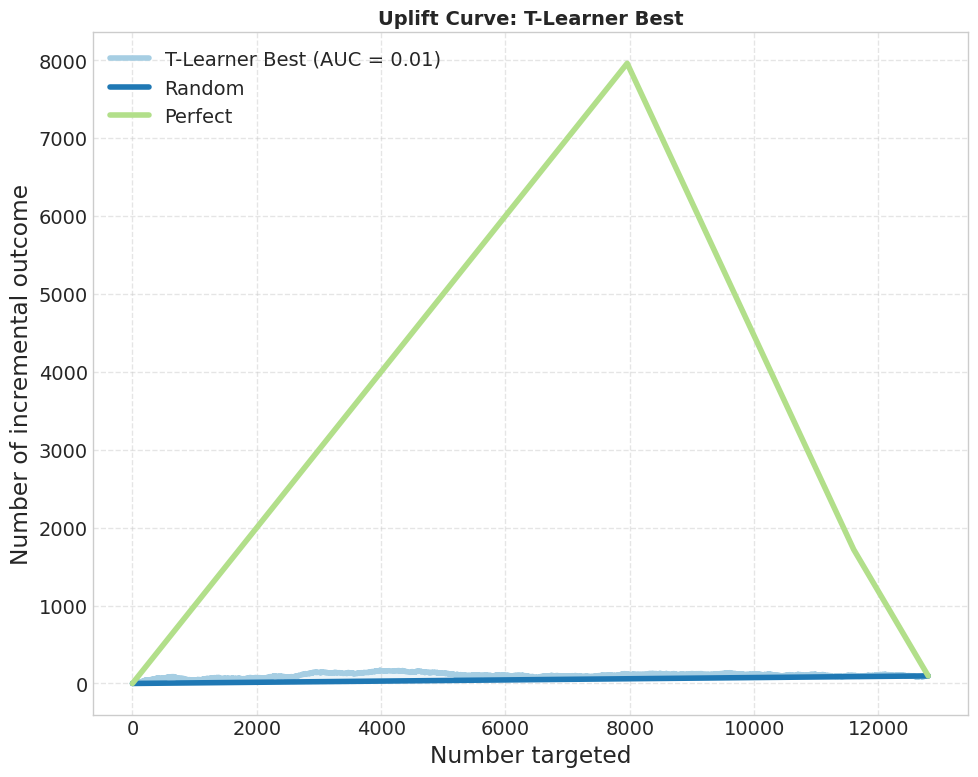

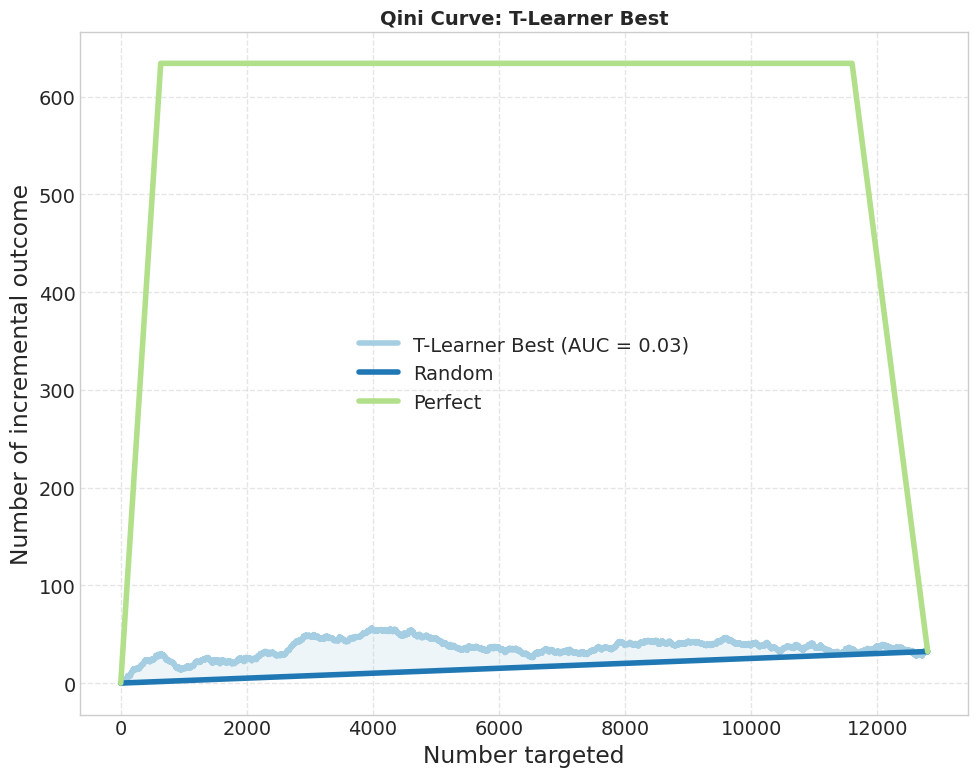

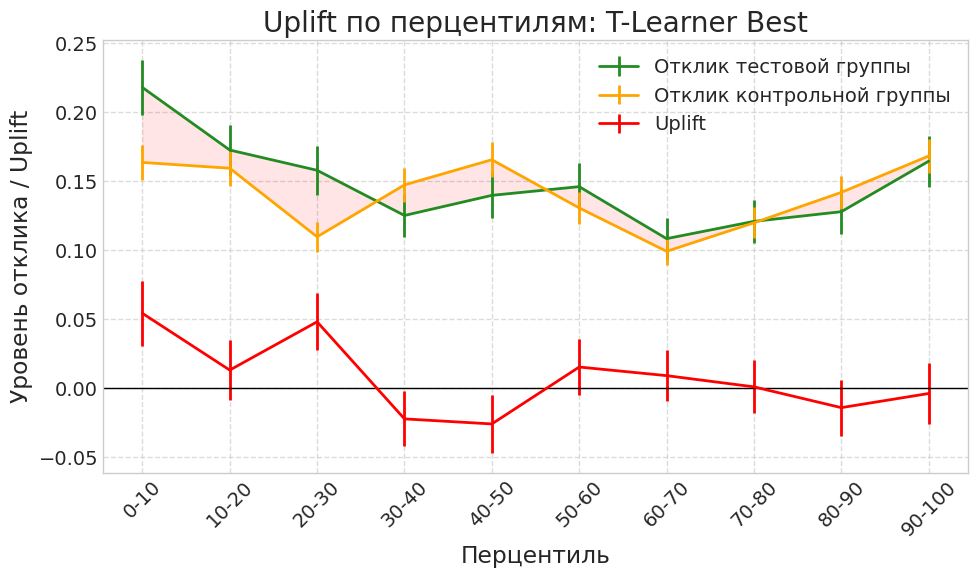

<Figure size 1000x600 with 0 Axes>

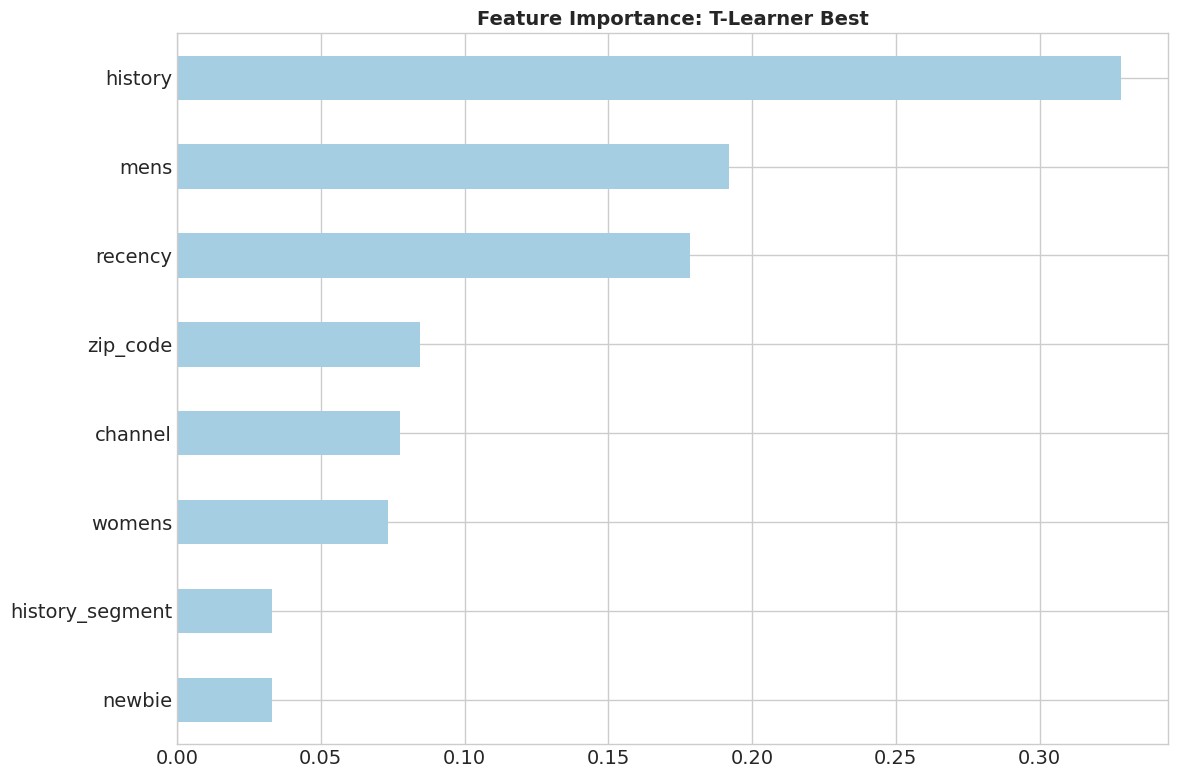

МЕТРИКИ ЛУЧШЕЙ МОДЕЛИ (T-Learner)
Uplift AUC:   0.0146
Qini AUC:     0.0338
Uplift@30%:   0.0388


In [16]:
#  ПОЛУЧАЕМ ПРЕДСКАЗАНИЯ 
uplift_pred = t_learner.predict(X_test.values).squeeze()

#  ВЫЧИСЛЯЕМ МЕТРИКИ 
uplift_auc = uplift_auc_score(y_test.values, uplift_pred, treatment_test.values)
qini_auc = qini_auc_score(y_test.values, uplift_pred, treatment_test.values)
uplift_30 = uplift_at_k(y_test.values, uplift_pred, treatment_test.values, strategy='overall', k=0.3)

#  UPLIFT CURVE 
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_uplift_curve(y_test.values, uplift_pred, treatment_test.values, 
                  perfect=True, ax=ax, name='T-Learner Best')
ax.legend()
ax.grid(True, linestyle="--", alpha=0.5)
plt.title('Uplift Curve: T-Learner Best', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

#  QINI CURVE 
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_qini_curve(y_test.values, uplift_pred, treatment_test.values, 
                perfect=True, ax=ax, name='T-Learner Best')
ax.legend()
ax.grid(True, linestyle="--", alpha=0.5)
plt.title('Qini Curve: T-Learner Best', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

#  UPLIFT по перцентилям 
fig = custom_uplift_by_percentile(
    y_true=y_test.values,
    uplift=uplift_pred,
    treatment=treatment_test.values,
    kind='line',
    bins=10,
    title='Uplift по перцентилям: T-Learner Best'
)
plt.show()

#  FEATURE IMPORTANCE 
plt.figure(figsize=(10, 6))
t_learner.plot_importance(
    X=X_test.values, 
    tau=uplift_pred, 
    features=X_test.columns.tolist()
)
plt.title('Feature Importance: T-Learner Best', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

#  МЕТРИКИ 
print("МЕТРИКИ ЛУЧШЕЙ МОДЕЛИ (T-Learner)")
print(f"Uplift AUC:   {uplift_auc:.4f}")
print(f"Qini AUC:     {qini_auc:.4f}")
print(f"Uplift@30%:   {uplift_30:.4f}")


Метрики очень низкие. Пробуем другие модели.

# Обучение 2 моделей 

### Обучение модели 1

In [17]:
#  MLflow и базовые настройки 
mlflow.set_tracking_uri("http://0.0.0.0:5000")
mlflow.set_experiment("s_learner")

models = {
    'RandomForest': RandomForestClassifier(n_estimators=1000, max_depth=8, random_state=42, n_jobs=-1, verbose=0),
    'LightGBM': LGBMClassifier(n_estimators=500, max_depth=6, random_state=42, n_jobs=-1, verbose=-1),
    'CatBoost': CatBoostClassifier(iterations=500, depth=6, random_state=42, verbose=False),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=1000, max_depth=6, random_state=42, verbose=0)
}

results_s = []

for name, model in models.items():
    with mlflow.start_run(run_name=f"S-Learner_{name}"):
        print(f"Обучение S-Learner с {name}...")
        
        # Логируем параметры
        mlflow.log_param("meta_algorithm", "S-Learner")
        mlflow.log_param("base_model", name)
        mlflow.log_param("n_features", X_train.shape[1])
        
        # Инициализация и обучение
        s_learner = BaseSClassifier(
            learner=model,
            control_name='control'
        )
        s_learner.fit(
            X=X_train.values,
            treatment=treatment_train_mapped.values,
            y=y_train.values
        )
        
       
        # Предсказания
        X_test_copy = X_test.values.copy()
        X_test_copy.setflags(write=True)  # разрешаем запись
        plift_pred = s_learner.predict(X_test_copy).squeeze()

        
        # Метрики
        uplift_auc = uplift_auc_score(y_test.values, uplift_pred, treatment_test.values)
        qini_auc = qini_auc_score(y_test.values, uplift_pred, treatment_test.values)
        uplift_30 = uplift_at_k(y_test.values, uplift_pred, treatment_test.values, strategy='overall', k=0.3)
        
        # Логирование метрик
        mlflow.log_metric("uplift_auc", uplift_auc)
        mlflow.log_metric("qini_auc", qini_auc)
        mlflow.log_metric("uplift_at_30", uplift_30)
        mlflow.log_metric("mean_uplift", uplift_pred.mean())
        mlflow.log_metric("std_uplift", uplift_pred.std())

        
        
        # Логирование модели
        from mlflow.models.signature import infer_signature
        signature = infer_signature(X_train.values[:5], uplift_pred[:5])
        
        mlflow.sklearn.log_model(
            s_learner,
            artifact_path=f"model",
            signature=signature,
            input_example=X_train.values[:5]
        )
        
        # Сохраняем результат в список
        results_s.append({
            'Model': name,
            'Uplift_AUC': uplift_auc,
            'Qini_AUC': qini_auc,
            'Uplift@30%': uplift_30,   
            'Model_Object': s_learner
        })
        
        print(f"{name}: AUC={uplift_auc:.4f} | Qini={qini_auc:.4f} | U@30%={uplift_30:.4f}")

#  ИТОГОВОЕ СРАВНЕНИЕ 
df_s = pd.DataFrame(results_s).sort_values('Uplift@30%', ascending=False)
print("ИТОГОВОЕ СРАВНЕНИЕ S-LEARNER")
print(df_s.to_string(index=False))

# Достаём лучшую модель
best_model_name_s = df_s.iloc[0]['Model']
best_s_learner = next(item['Model_Object'] for item in results_s if item['Model'] == best_model_name_s)

print(f"\nЛучшая модель: {best_model_name_s} с Uplift@30% = {df_s.iloc[0]['Uplift@30%']:.4f}")


Обучение S-Learner с RandomForest...


2025/11/06 00:14:53 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


RandomForest: AUC=0.0146 | Qini=0.0338 | U@30%=0.0388
🏃 View run S-Learner_RandomForest at: http://0.0.0.0:5000/#/experiments/27/runs/6a514ba46baf401fad4518ca0c039623
🧪 View experiment at: http://0.0.0.0:5000/#/experiments/27
Обучение S-Learner с LightGBM...


2025/11/06 00:15:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


LightGBM: AUC=0.0146 | Qini=0.0338 | U@30%=0.0388
🏃 View run S-Learner_LightGBM at: http://0.0.0.0:5000/#/experiments/27/runs/cb79538d1b6542e8963a2c58e25aea6d
🧪 View experiment at: http://0.0.0.0:5000/#/experiments/27
Обучение S-Learner с CatBoost...


2025/11/06 00:15:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


CatBoost: AUC=0.0146 | Qini=0.0338 | U@30%=0.0388
🏃 View run S-Learner_CatBoost at: http://0.0.0.0:5000/#/experiments/27/runs/bc489c603ae14f63a56987c8990892a4
🧪 View experiment at: http://0.0.0.0:5000/#/experiments/27
Обучение S-Learner с GradientBoosting...


2025/11/06 00:16:50 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


GradientBoosting: AUC=0.0146 | Qini=0.0338 | U@30%=0.0388
🏃 View run S-Learner_GradientBoosting at: http://0.0.0.0:5000/#/experiments/27/runs/77c0b4995a7944a0bcf538472c18698e
🧪 View experiment at: http://0.0.0.0:5000/#/experiments/27
ИТОГОВОЕ СРАВНЕНИЕ S-LEARNER
           Model  Uplift_AUC  Qini_AUC  Uplift@30%                                                                                                                      Model_Object
    RandomForest    0.014646  0.033786    0.038807 BaseSClassifier(model=RandomForestClassifier(max_depth=8, n_estimators=1000, n_jobs=-1,\n                       random_state=42))
        LightGBM    0.014646  0.033786    0.038807      BaseSClassifier(model=LGBMClassifier(max_depth=6, n_estimators=500, n_jobs=-1, random_state=42,\n               verbose=-1))
        CatBoost    0.014646  0.033786    0.038807                                                BaseSClassifier(model=<catboost.core.CatBoostClassifier object at 0x7fd260335510>)
GradientBoost

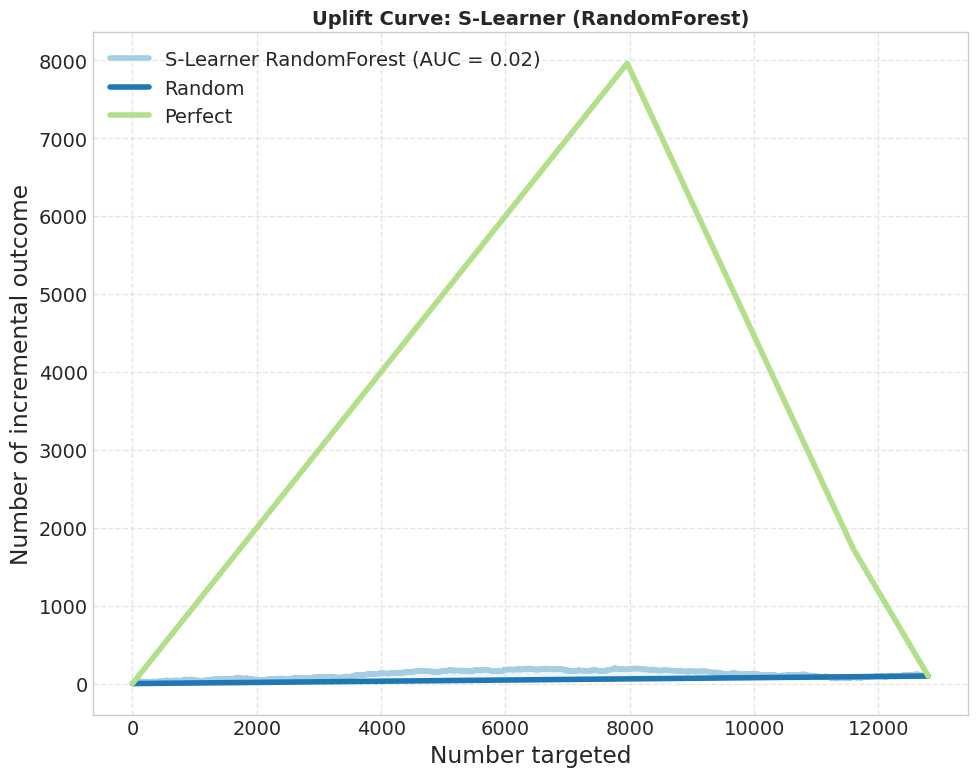

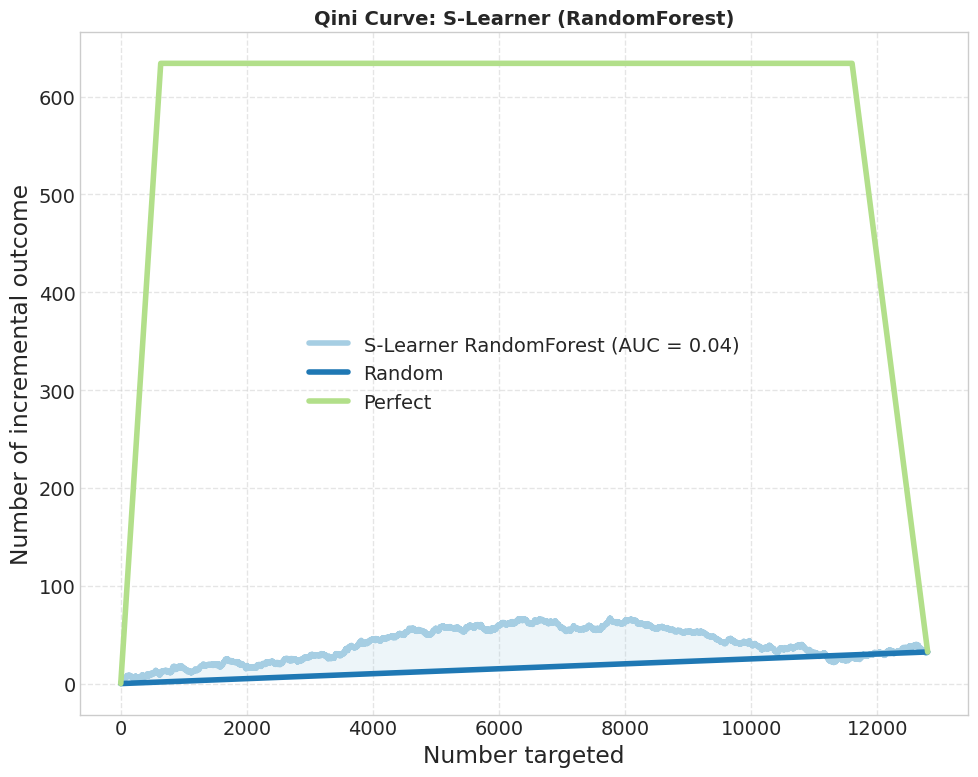

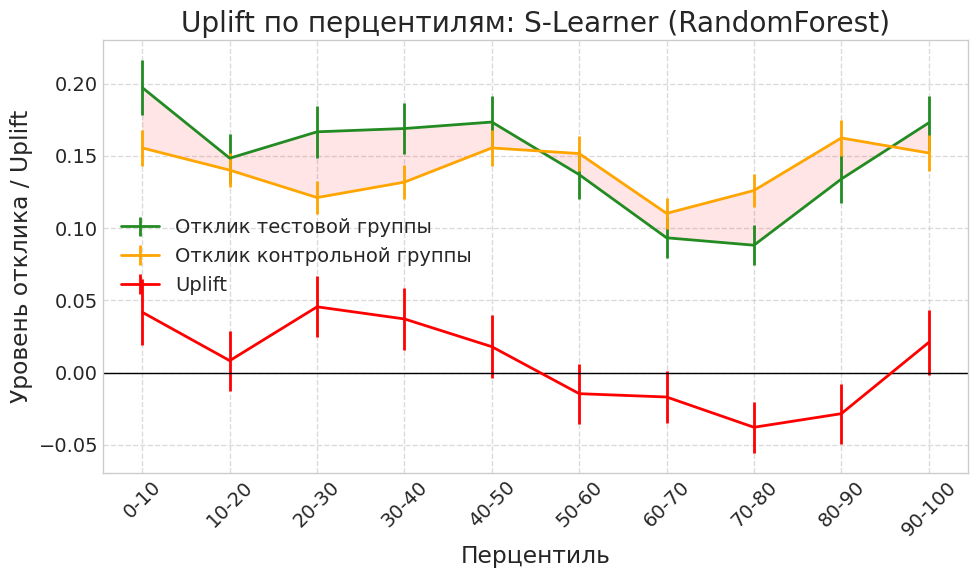

<Figure size 1000x600 with 0 Axes>

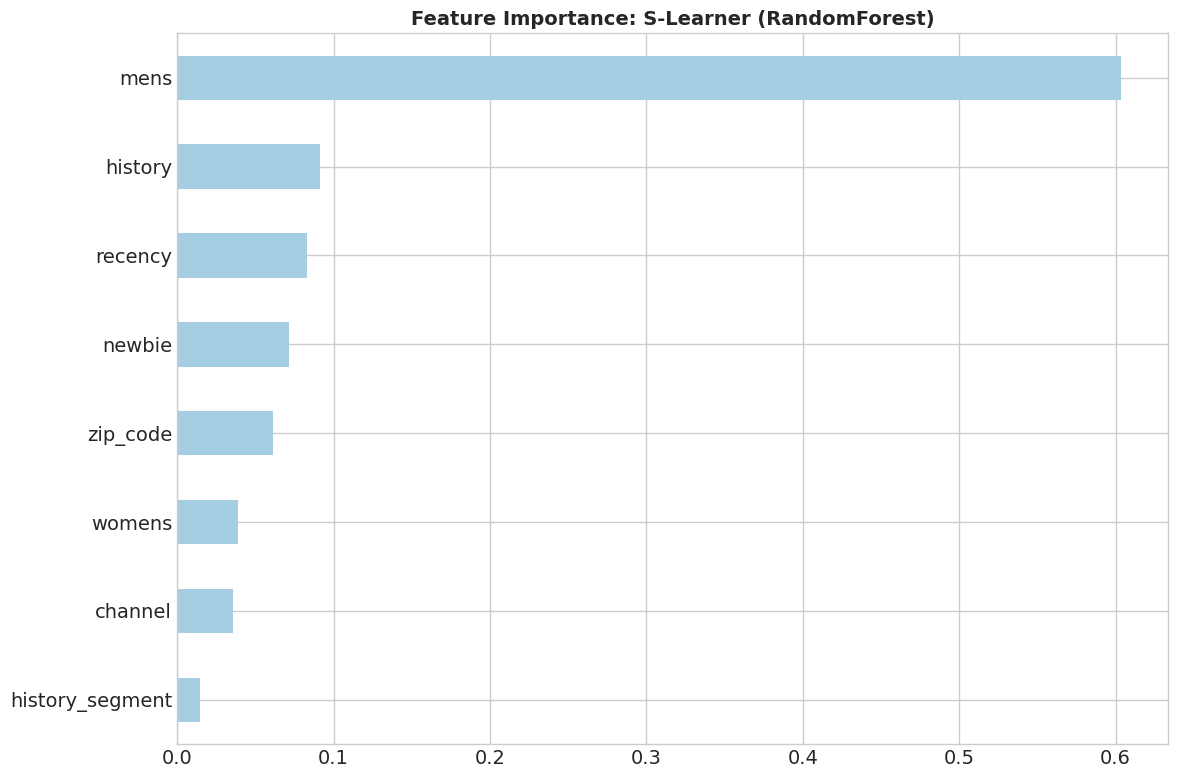

МЕТРИКИ ЛУЧШЕЙ МОДЕЛИ (S-Learner)
Uplift AUC:   0.0177
Qini AUC:     0.0409
Uplift@30%:   0.0317


In [18]:
#  ПРЕДСКАЗАНИЯ 
uplift_pred_s_best = best_s_learner.predict(X_test.values).squeeze()

# МЕТРИКИ 
uplift_auc_s = uplift_auc_score(y_test.values, uplift_pred_s_best, treatment_test.values)
qini_auc_s = qini_auc_score(y_test.values, uplift_pred_s_best, treatment_test.values)
uplift_30_s = uplift_at_k(y_test.values, uplift_pred_s_best, treatment_test.values, strategy='overall', k=0.3)

#  UPLIFT CURVE 
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_uplift_curve(y_test.values, uplift_pred_s_best, treatment_test.values, 
                  perfect=True, ax=ax, name=f'S-Learner {best_model_name_s}')
ax.legend()
ax.grid(True, linestyle="--", alpha=0.5)
plt.title(f'Uplift Curve: S-Learner ({best_model_name_s})', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

#  QINI CURVE 
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_qini_curve(y_test.values, uplift_pred_s_best, treatment_test.values, 
                perfect=True, ax=ax, name=f'S-Learner {best_model_name_s}')
ax.legend()
ax.grid(True, linestyle="--", alpha=0.5)
plt.title(f'Qini Curve: S-Learner ({best_model_name_s})', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

#  UPLIFT по перцентилям 
fig = custom_uplift_by_percentile(
    y_true=y_test.values,
    uplift=uplift_pred_s_best,
    treatment=treatment_test.values,
    kind='line',
    bins=10,
    title=f'Uplift по перцентилям: S-Learner ({best_model_name_s})'
)
plt.show()

#  FEATURE IMPORTANCE 
plt.figure(figsize=(10, 6))
best_s_learner.plot_importance(
    X=X_test.values, 
    tau=uplift_pred_s_best, 
    features=X_test.columns.tolist()
)
plt.title(f'Feature Importance: S-Learner ({best_model_name_s})', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

#  ФИНАЛЬНЫЕ МЕТРИКИ 
print("МЕТРИКИ ЛУЧШЕЙ МОДЕЛИ (S-Learner)")
print(f"Uplift AUC:   {uplift_auc_s:.4f}")
print(f"Qini AUC:     {qini_auc_s:.4f}")
print(f"Uplift@30%:   {uplift_30_s:.4f}")


Одинаково плохо. Попробуем X-learner, но без CatBoost. Слишком тяжел, ошибки памяти.

### Обучение модели 2

In [19]:
results_x = []

models = [
    ("RandomForest", 
     RandomForestClassifier(n_estimators=500, max_depth=8, random_state=42, n_jobs=-1),
     RandomForestRegressor(n_estimators=500, max_depth=8, random_state=42, n_jobs=-1)),

    ("LightGBM", 
     LGBMClassifier(n_estimators=500, max_depth=8, random_state=42, n_jobs=-1, verbose=-1),
     LGBMRegressor(n_estimators=500, max_depth=8, random_state=42, n_jobs=-1, verbose=-1)),

    ("GradientBoosting", 
     GradientBoostingClassifier(n_estimators=500, max_depth=5, random_state=42),
     GradientBoostingRegressor(n_estimators=500, max_depth=5, random_state=42))
]

mlflow.set_experiment("X-Learner")

for name, outcome_model, effect_model in models:
    print(f"Обучаем {name} ...")
    start_time = time.time()

    with mlflow.start_run(run_name=f"X-Learner_{name}"):
        #  инициализация X-Learner
        x_learner = BaseXClassifier(
            outcome_learner=outcome_model,
            effect_learner=effect_model,
            control_name='control'
        )

        #  обучение
        x_learner.fit(
            X=X_train.values.copy(),
            treatment=treatment_train_mapped.values,
            y=y_train.values
        )

        #  предсказания
        X_test_copy = X_test.values.copy()
        X_test_copy.flags.writeable = True
        uplift_pred = x_learner.predict(X=X_test_copy).squeeze()

        #  метрики
        uplift_auc = uplift_auc_score(y_test.values, uplift_pred, treatment_test.values)
        qini_auc = qini_auc_score(y_test.values, uplift_pred, treatment_test.values)
        uplift_30 = uplift_at_k(y_test.values, uplift_pred, treatment_test.values, strategy='overall', k=0.3)
        duration = time.time() - start_time

        #  логирование в MLflow
        mlflow.log_metric("uplift_auc", auc)
        mlflow.log_metric("qini_auc", qini)
        mlflow.log_metric("uplift_at_30", u30)
        mlflow.log_metric("mean_uplift", uplift.mean())
        mlflow.log_metric("std_uplift", uplift.std())

        mlflow.sklearn.log_model(x_learner, artifact_path="x_learner_model", signature=signature, input_example=X_train.values[:5])

        print(f"{name} обучен | Uplift AUC={uplift_auc:.4f} | Qini AUC={qini_auc:.4f} | Uplift@30%={uplift_30:.4f}")

        results_x.append({
            "Model": name,
            "Uplift AUC": uplift_auc,
            "Qini AUC": qini_auc,
            "Uplift@30%": uplift_30,
            "Time (s)": duration,
            "Model_Object": x_learner
        })

#  ИТОГОВОЕ СРАВНЕНИЕ
df_x = pd.DataFrame(results_x).sort_values(by="Uplift AUC", ascending=False)
print("\nИТОГОВОЕ СРАВНЕНИЕ X-Learner моделей:")
display(df_x)

#  Лучшая модель
best_x_name = df_x.iloc[0]['Model']
best_x_model = next(item["Model_Object"] for item in results_x if item["Model"] == best_x_name)
print(f"Лучшая модель X-Learner: {best_x_name}")


Обучаем RandomForest ...


2025/11/06 00:18:20 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


RandomForest обучен | Uplift AUC=0.0235 | Qini AUC=0.0547 | Uplift@30%=0.0295
🏃 View run X-Learner_RandomForest at: http://0.0.0.0:5000/#/experiments/29/runs/fcc3d7bb1ec84f81912258ef9bbf377d
🧪 View experiment at: http://0.0.0.0:5000/#/experiments/29
Обучаем LightGBM ...


2025/11/06 00:19:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


LightGBM обучен | Uplift AUC=0.0100 | Qini AUC=0.0228 | Uplift@30%=0.0195
🏃 View run X-Learner_LightGBM at: http://0.0.0.0:5000/#/experiments/29/runs/a577612c8299426ea5ca2b43377a1629
🧪 View experiment at: http://0.0.0.0:5000/#/experiments/29
Обучаем GradientBoosting ...


2025/11/06 00:21:52 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


GradientBoosting обучен | Uplift AUC=0.0166 | Qini AUC=0.0374 | Uplift@30%=0.0275
🏃 View run X-Learner_GradientBoosting at: http://0.0.0.0:5000/#/experiments/29/runs/030cd3fbb8bb49f7b28bda5bf13801fa
🧪 View experiment at: http://0.0.0.0:5000/#/experiments/29

ИТОГОВОЕ СРАВНЕНИЕ X-Learner моделей:


,Model,Uplift AUC,Qini AUC,Uplift@30%,Time (s),Model_Object
0,RandomForest,0.023546,0.054670,0.029527,81.566959,BaseXClassifier(control_outcome_learner=Random...
2,GradientBoosting,0.016613,0.037385,0.027543,136.345841,BaseXClassifier(control_outcome_learner=Gradie...
1,LightGBM,0.010025,0.022839,0.019535,63.950492,BaseXClassifier(control_outcome_learner=LGBMCl...


Лучшая модель X-Learner: RandomForest


### Получение метрик по модели 2

МЕТРИКИ ЛУЧШЕГО X-LEARNER
Uplift AUC:  0.0235
Qini AUC:    0.0547
Uplift@30%:  0.0295


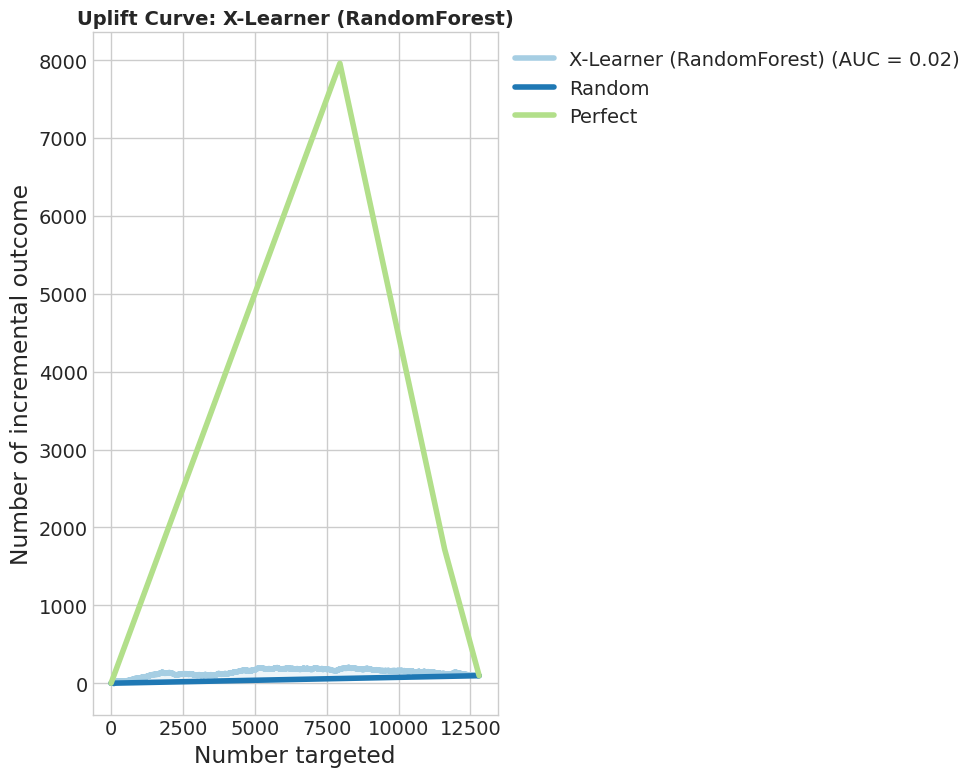

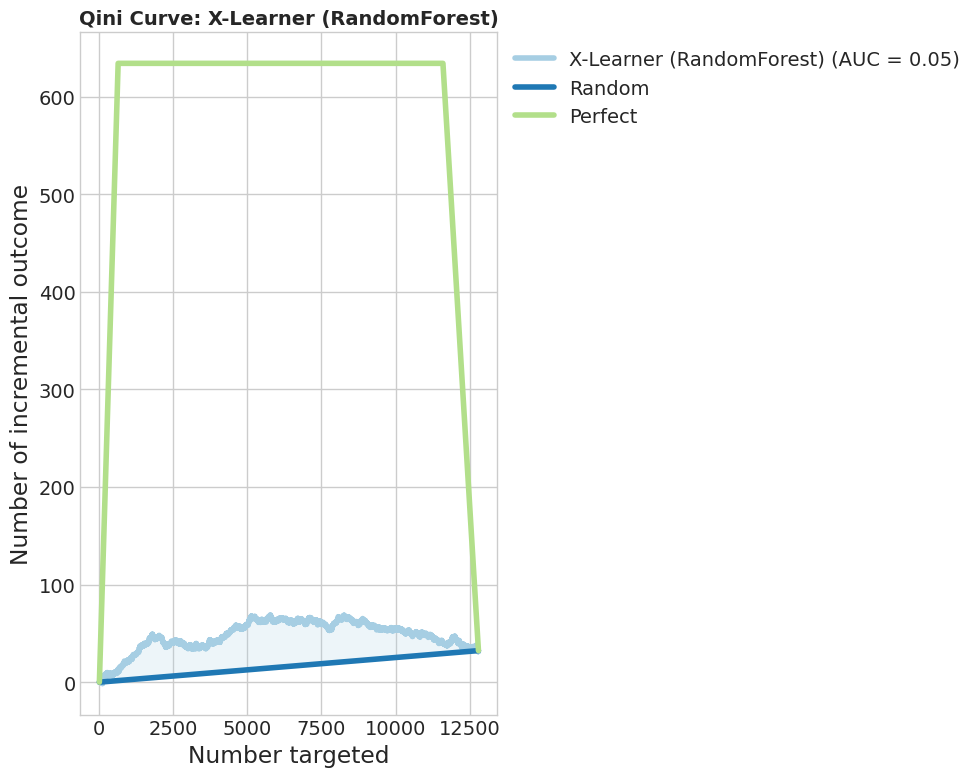

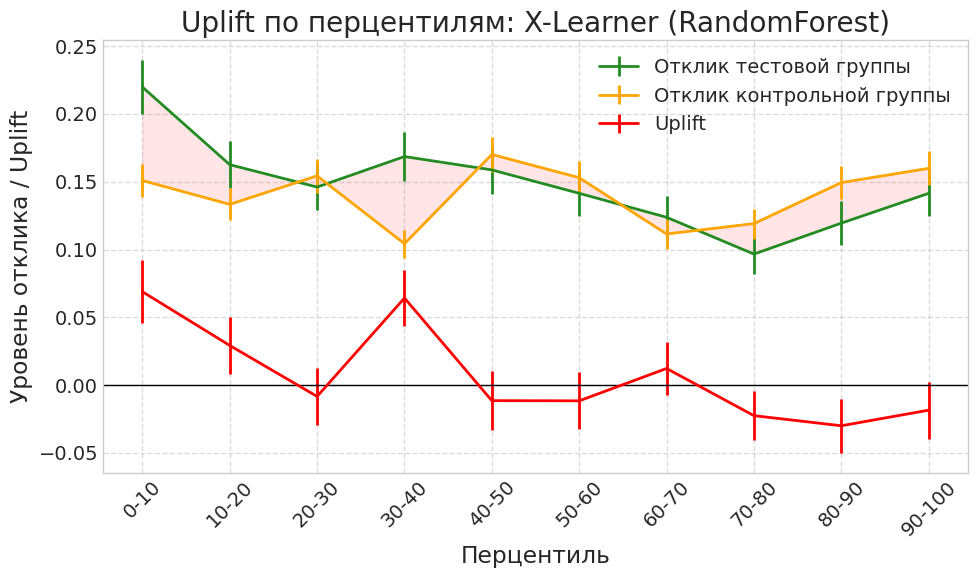

<Figure size 1000x600 with 0 Axes>

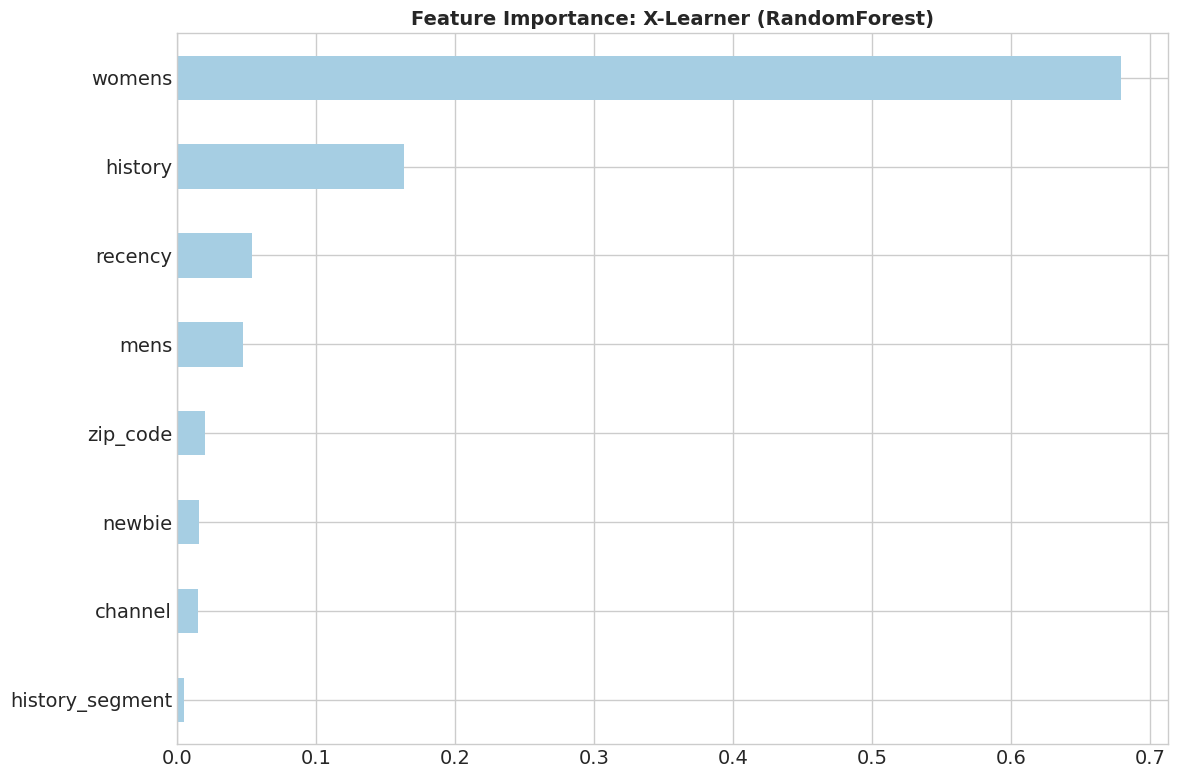

In [20]:
# Предсказания
X_test_copy = X_test.values.copy()
X_test_copy.flags.writeable = True
uplift_pred_best_x = best_x_model.predict(X=X_test_copy).squeeze()

# Метрики
uplift_auc_x = uplift_auc_score(y_test.values, uplift_pred_best_x, treatment_test.values)
qini_auc_x = qini_auc_score(y_test.values, uplift_pred_best_x, treatment_test.values)
uplift_30_x = uplift_at_k(y_test.values, uplift_pred_best_x, treatment_test.values, strategy='overall', k=0.3)

print("МЕТРИКИ ЛУЧШЕГО X-LEARNER")
print(f"Uplift AUC:  {uplift_auc_x:.4f}")
print(f"Qini AUC:    {qini_auc_x:.4f}")
print(f"Uplift@30%:  {uplift_30_x:.4f}")

#  UPLIFT CURVE
fig, ax = plt.subplots(figsize=(10, 8))
plot_uplift_curve(y_test.values, uplift_pred_best_x, treatment_test.values, perfect=True, ax=ax, name=f'X-Learner ({best_x_name})')
plt.title(f'Uplift Curve: X-Learner ({best_x_name})', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

#  QINI CURVE
fig, ax = plt.subplots(figsize=(10, 8))
plot_qini_curve(y_test.values, uplift_pred_best_x, treatment_test.values, perfect=True, ax=ax, name=f'X-Learner ({best_x_name})')
plt.title(f'Qini Curve: X-Learner ({best_x_name})', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

#  UPLIFT ПО ПЕРЦЕНТИЛЯМ
fig = custom_uplift_by_percentile(
    y_true=y_test.values,
    uplift=uplift_pred_best_x,
    treatment=treatment_test.values,
    kind='line',
    bins=10,
    title=f'Uplift по перцентилям: X-Learner ({best_x_name})'
)
plt.show()

#  FEATURE IMPORTANCE
plt.figure(figsize=(10, 6))
best_x_model.plot_importance(
    X=X_test.values,
    tau=uplift_pred_best_x,
    features=X_test.columns.tolist()
)
plt.title(f'Feature Importance: X-Learner ({best_x_name})', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


In [21]:

#  НАСТРОЙКА MLFLOW 
mlflow.set_tracking_uri("http://0.0.0.0:5000")
mlflow.set_experiment("R-Learner_with_propensity")

#  ШАГ 1: ОБУЧЕНИЕ PROPENSITY SCORE MODEL 

print("ШАГ 1: Обучение Propensity Score модели")


# Подготовка данных для propensity
features = X_train.columns.tolist()
T_train = treatment_train.values  # 1 - treatment, 0 - control
T_test = treatment_test.values

# Propensity model
propensity_model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=4,
    random_state=42,
    verbosity=0
)

propensity_model.fit(X_train.values, T_train)

# Propensity scores
p_train = propensity_model.predict_proba(X_train.values)[:, 1]
p_test = propensity_model.predict_proba(X_test.values)[:, 1]

roc_auc_propensity = roc_auc_score(T_test, p_test)
print(f"Propensity Score ROC AUC: {roc_auc_propensity:.4f}\n")

# R-LEARNER С РАЗНЫМИ МОДЕЛЯМИ 

print("ШАГ 2: Обучение R-Learner с разными базовыми моделями")


results_r = []

# Модели для тестирования
models = [
    ("XGBoost",
     XGBClassifier(n_estimators=1000, learning_rate=0.05, max_depth=6, random_state=42, verbosity=0),
     XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=6, random_state=42, verbosity=0),
     XGBClassifier(n_estimators=1000, learning_rate=0.05, max_depth=6, random_state=42, verbosity=0)),
    
    ("RandomForest",
     RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=42, n_jobs=-1, verbose=0),
     RandomForestRegressor(n_estimators=1000, max_depth=10, random_state=42, n_jobs=-1, verbose=0),
     RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=42, n_jobs=-1, verbose=0)),

    ("CatBoost",
     CatBoostClassifier(iterations=200, depth=6, random_state=42, verbose=False),
     CatBoostRegressor(iterations=200, depth=6, random_state=42, verbose=False),
     CatBoostClassifier(iterations=200, depth=6, random_state=42, verbose=False))
]

for name, outcome_model, effect_model, propensity_learner in models:
    with mlflow.start_run(run_name=f"R-Learner_{name}"):
        print(f"\nОбучение R-Learner с {name}...")
        start_time = time.time()
        
        # Логируем параметры
        mlflow.log_param("meta_algorithm", "R-Learner")
        mlflow.log_param("base_model", name)
        mlflow.log_param("n_features", X_train.shape[1])
        mlflow.log_param("train_size", len(X_train))
        mlflow.log_param("test_size", len(X_test))
        mlflow.log_param("propensity_roc_auc", roc_auc_propensity)
        
        # Создаём R-Learner с propensity
        r_learner = BaseRClassifier(
            outcome_learner=outcome_model,
            effect_learner=effect_model,
            propensity_learner=propensity_learner
        )
        
        # Обучение
        r_learner.fit(
            X=X_train.values,
            treatment=T_train,
            y=y_train.values,
            verbose=False
        )
        
        # Предсказания
        uplift_pred = r_learner.predict(X_test.values).squeeze()
        
        # Метрики
        uplift_auc = uplift_auc_score(y_test.values, uplift_pred, T_test)
        qini_auc = qini_auc_score(y_test.values, uplift_pred, T_test)
        uplift_30 = uplift_at_k(y_test.values, uplift_pred, T_test, strategy='overall', k=0.3)
        duration = time.time() - start_time
        
        # Логирование метрик (БЕЗ модели - избегаем S3)
        mlflow.log_metric("uplift_auc", uplift_auc)
        mlflow.log_metric("qini_auc", qini_auc)
        mlflow.log_metric("uplift_at_30", uplift_30)
        mlflow.log_metric("mean_uplift", uplift_pred.mean())
        mlflow.log_metric("std_uplift", uplift_pred.std())
        
        # Сохраняем результаты
        results_r.append({
            "Model": name,
            "Uplift_AUC": uplift_auc,
            "Qini_AUC": qini_auc,
            "Uplift@30%": uplift_30,
            "Time (s)": duration,
            "Model_Object": r_learner
        })
        
        print(f"{name}: AUC={uplift_auc:.4f} | Qini={qini_auc:.4f} | U@30%={uplift_30:.4f} | Time={duration:.1f}s")

#  СРАВНЕНИЕ РЕЗУЛЬТАТОВ 



print("ИТОГОВОЕ СРАВНЕНИЕ R-LEARNER")

results_df = pd.DataFrame(results_r).sort_values('Uplift@30%', ascending=False)
print(results_df.to_string(index=False))


best_model = results_df.iloc[0]['Model']
best_score = results_df.iloc[0]['Uplift@30%']
print(f"\nЛучшая модель: {best_model} с Uplift@30% = {best_score:.4f}")


ШАГ 1: Обучение Propensity Score модели


Propensity Score ROC AUC: 0.4991

ШАГ 2: Обучение R-Learner с разными базовыми моделями

Обучение R-Learner с XGBoost...
XGBoost: AUC=0.0068 | Qini=0.0160 | U@30%=0.0130 | Time=12.4s
🏃 View run R-Learner_XGBoost at: http://0.0.0.0:5000/#/experiments/31/runs/4df78834dd074e1898cff1f2bcd0a714
🧪 View experiment at: http://0.0.0.0:5000/#/experiments/31

Обучение R-Learner с RandomForest...
RandomForest: AUC=0.0211 | Qini=0.0495 | U@30%=0.0341 | Time=96.3s
🏃 View run R-Learner_RandomForest at: http://0.0.0.0:5000/#/experiments/31/runs/3a19d086b2c5499c87c79ba700f06adc
🧪 View experiment at: http://0.0.0.0:5000/#/experiments/31

Обучение R-Learner с CatBoost...
CatBoost: AUC=0.0171 | Qini=0.0393 | U@30%=0.0292 | Time=15.0s
🏃 View run R-Learner_CatBoost at: http://0.0.0.0:5000/#/experiments/31/runs/e38d207623674b7d9d20225073f78f3f
🧪 View experiment at: http://0.0.0.0:5000/#/experiments/31
ИТОГОВОЕ СРАВНЕНИЕ R-LEARNER
       Model  Uplift_AUC  Qini_AUC  Uplift@30%  Time (s)                       

Визуализация для лучшей модели R-Learner: RandomForest


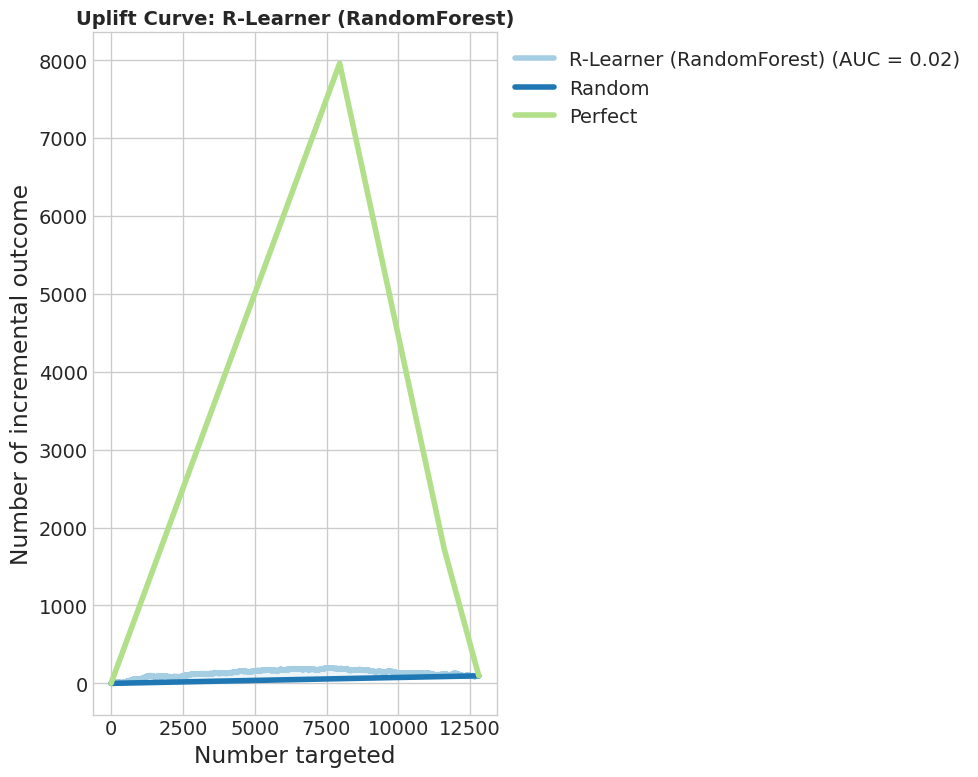

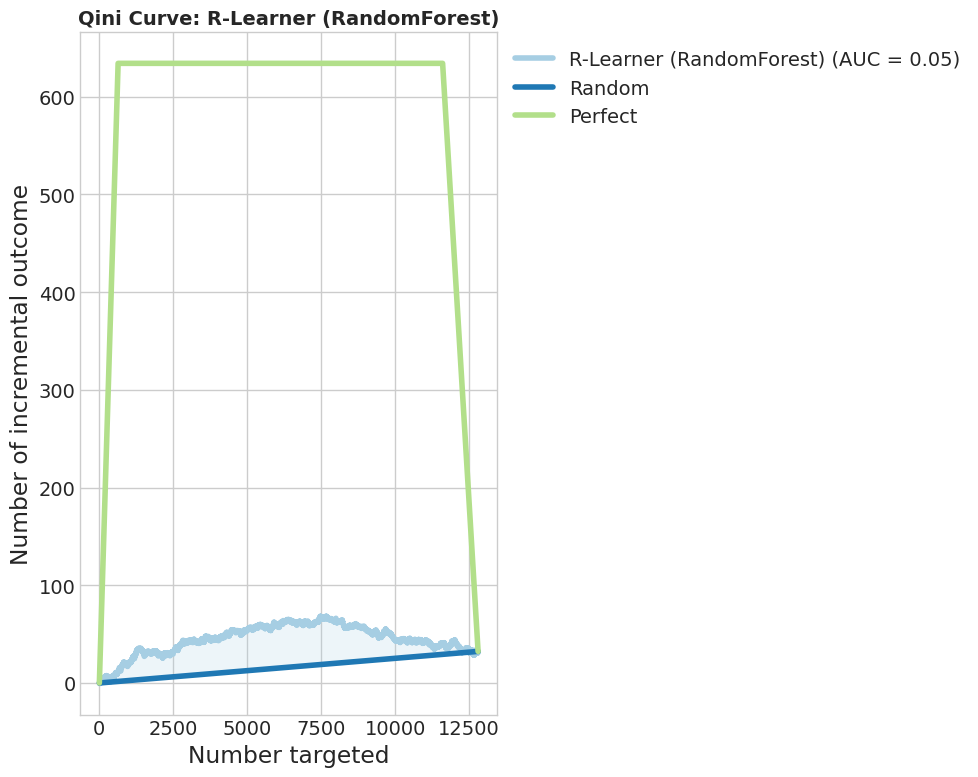

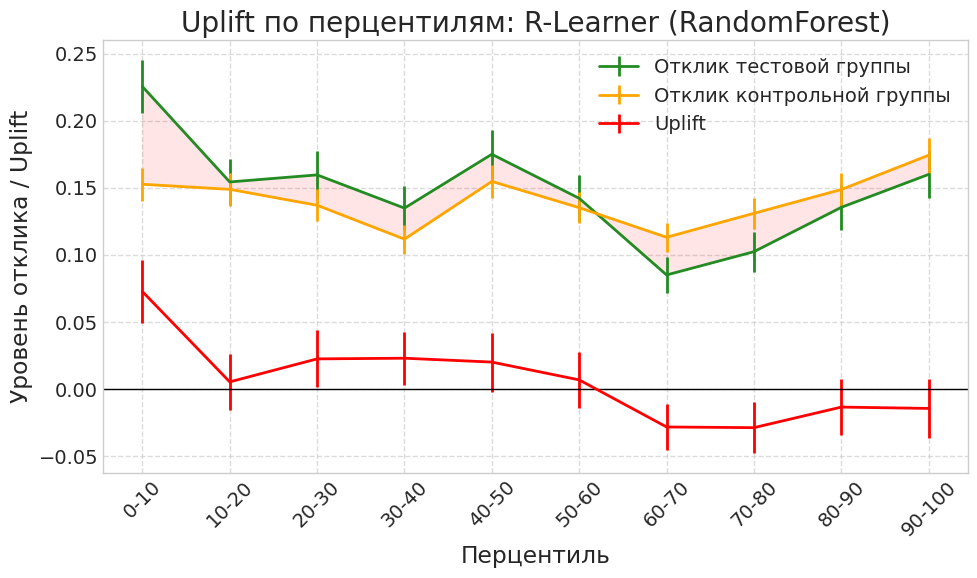

<Figure size 1000x600 with 0 Axes>

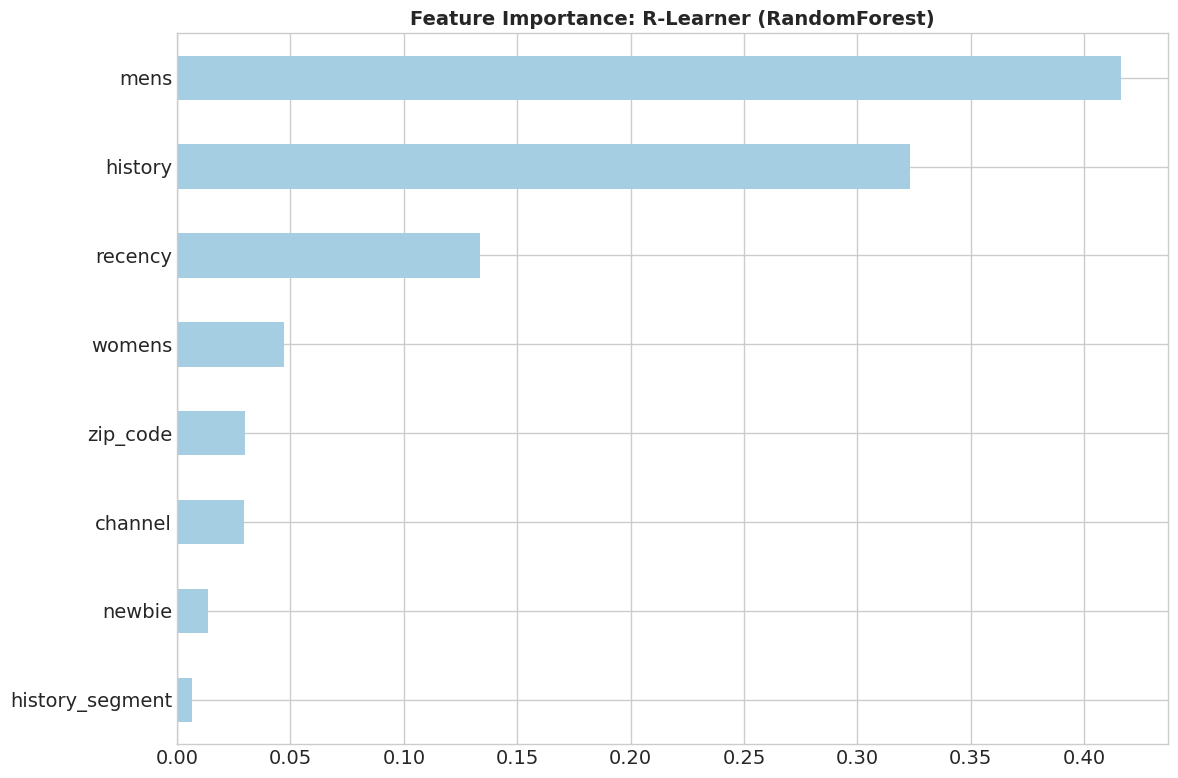


МЕТРИКИ ЛУЧШЕЙ МОДЕЛИ R-LEARNER
Uplift AUC:  0.0211
Qini AUC:    0.0495
Uplift@30%:  0.0341


In [23]:
# ВИЗУАЛИЗАЦИЯ ЛУЧШЕЙ МОДЕЛИ R-LEARNER 

# Находим лучшую модель по uplift AUC
best_result_r = max(results_r, key=lambda x: x["Uplift_AUC"])
best_r_name = best_result_r["Model"]
best_r_model = best_result_r["Model_Object"]

print(f"Визуализация для лучшей модели R-Learner: {best_r_name}")

#  ПРЕДСКАЗАНИЯ 
X_test_copy = X_test.values.copy()
X_test_copy.flags.writeable = True
uplift_pred_r = best_r_model.predict(X=X_test_copy).squeeze()

#  МЕТРИКИ 
uplift_auc_r = uplift_auc_score(y_test.values, uplift_pred_r, treatment_test.values)
qini_auc_r = qini_auc_score(y_test.values, uplift_pred_r, treatment_test.values)
uplift_30_r = uplift_at_k(
    y_test.values, uplift_pred_r, treatment_test.values,
    strategy='overall', k=0.3
)

#  UPLIFT CURVE 
fig, ax = plt.subplots(figsize=(10, 8))
plot_uplift_curve(
    y_test.values, uplift_pred_r, treatment_test.values,
    perfect=True, ax=ax, name=f'R-Learner ({best_r_name})'
)
plt.title(f'Uplift Curve: R-Learner ({best_r_name})', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

#  QINI CURVE 
fig, ax = plt.subplots(figsize=(10, 8))
plot_qini_curve(
    y_test.values, uplift_pred_r, treatment_test.values,
    perfect=True, ax=ax, name=f'R-Learner ({best_r_name})'
)
plt.title(f'Qini Curve: R-Learner ({best_r_name})', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

#  UPLIFT ПО ПЕРЦЕНТИЛЯМ 
fig = custom_uplift_by_percentile(
    y_true=y_test.values,
    uplift=uplift_pred_r,
    treatment=treatment_test.values,
    kind='line',
    bins=10,
    title=f'Uplift по перцентилям: R-Learner ({best_r_name})'
)
plt.show()

#  FEATURE IMPORTANCE 
try:
    plt.figure(figsize=(10, 6))
    best_r_model.plot_importance(
        X=X_test.values,
        tau=uplift_pred_r,
        features=X_test.columns.tolist()
    )
    plt.title(f'Feature Importance: R-Learner ({best_r_name})', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
except AttributeError:
    print(f" Модель {best_r_name} не поддерживает метод plot_importance().")

#  МЕТРИКИ 
print("\nМЕТРИКИ ЛУЧШЕЙ МОДЕЛИ R-LEARNER")
print(f"Uplift AUC:  {uplift_auc_r:.4f}")
print(f"Qini AUC:    {qini_auc_r:.4f}")
print(f"Uplift@30%:  {uplift_30_r:.4f}")


Все метрики невысокие. Смена моделей прироста не дает.Идем в улучшение модели с X-Learner. Он чуть луше улавливает связи в данных.

# Часть 2

## Этап 1
Улучшим бейзлайн выбранной модели

#### Генерация признаков 

In [36]:
df = pd.read_csv(r"/home/mle-user/mle_projects/uplift_modelLing_food_app/uplift_fp_data.csv")


In [110]:
#  FEATURE ENGINEERING 
print("Feature Engineering...")

# Добавим взаимодействия с высоким uplift
df['womens_x_recency_high'] = df['womens'] * (df['recency'] >= 7).astype(int)
df['premium_inactive'] = (df['history_segment'] >= 5) * (df['recency'] >= 6).astype(int)
df['newbie_womens_high_recency'] = df['newbie'] * df['womens'] * (df['recency'] >= 7).astype(int)

print(f"Базовые признаки: {df.shape[1]}")

# Разбивка данных
X = df.drop(['target', 'treatment', 'history'], axis=1)
y = df['target']
treatment = df['treatment']

X_train, X_test, y_train, y_test, treatment_train, treatment_test = train_test_split(
    X, y, treatment, test_size=0.3, random_state=42, stratify=treatment
)

# Маппинг
treatment_mapping = {0: 'control', 1: 'treatment'}
treatment_train_mapped = treatment_train.map(treatment_mapping)
treatment_test_mapped = treatment_test.map(treatment_mapping)

# Полиномиальные признаки для важных фич
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
important_features = ['recency', 'history_segment', 'womens', 'mens']

X_train_poly = poly.fit_transform(X_train[important_features])
X_test_poly = poly.transform(X_test[important_features])

# Объединяем с остальными признаками
other_features = [col for col in X_train.columns if col not in important_features]
X_train_full = np.hstack([X_train[other_features].values, X_train_poly])
X_test_full = np.hstack([X_test[other_features].values, X_test_poly])

print(f"После poly features: {X_train_full.shape[1]} признаков")

Feature Engineering...
Базовые признаки: 13
После poly features: 16 признаков


In [39]:
results_rf = []

mlflow.set_tracking_uri("http://0.0.0.0:5000")
mlflow.set_experiment("X-Learner_RF_NewFeatures")


print("Обучаем X-Learner RandomForest с новыми признаками...")

start_time = time.time()

with mlflow.start_run(run_name="X-Learner_RF_NewFeatures"):
    
    # Логируем параметры
    mlflow.log_param("meta_algorithm", "X-Learner")
    mlflow.log_param("base_model", "RandomForest")
    mlflow.log_param("n_features", X_train_full.shape[1])
    mlflow.log_param("train_size", len(X_train_full))
    mlflow.log_param("test_size", len(X_test_full))
    mlflow.log_param("n_estimators", 500)
    mlflow.log_param("max_depth", 8)
    
    # Инициализация X-Learner
    x_learner = BaseXClassifier(
        outcome_learner=RandomForestClassifier(
            n_estimators=1000, 
            max_depth=8, 
            random_state=42, 
            n_jobs=-1,
            verbose=0
        ),
        effect_learner=RandomForestRegressor(
            n_estimators=1000, 
            max_depth=8, 
            random_state=42, 
            n_jobs=-1,
            verbose=0
        ),
        control_name='control'
    )

    # Обучение (X_train_full уже numpy array)
    x_learner.fit(
        X=X_train_full.copy(),
        treatment=treatment_train_mapped.values,
        y=y_train.values
    )

    # Предсказания
    X_test_copy = X_test_full.copy()
    X_test_copy.flags.writeable = True
    uplift_pred = x_learner.predict(X=X_test_copy).squeeze()

    # Метрики
    uplift_auc = uplift_auc_score(y_test.values, uplift_pred, treatment_test.values)
    qini_auc = qini_auc_score(y_test.values, uplift_pred, treatment_test.values)
    uplift_30 = uplift_at_k(y_test.values, uplift_pred, treatment_test.values, 
                            strategy='overall', k=0.3)
    duration = time.time() - start_time

    # Логирование метрик (БЕЗ модели - избегаем S3)
    mlflow.log_metric("uplift_auc", uplift_auc)
    mlflow.log_metric("qini_auc", qini_auc)
    mlflow.log_metric("uplift_at_30", uplift_30)
    mlflow.log_metric("mean_uplift", uplift_pred.mean())
    mlflow.log_metric("std_uplift", uplift_pred.std())
    mlflow.log_metric("training_time", duration)

    print(f"\nRF обучен | Uplift AUC={uplift_auc:.4f} | Qini={qini_auc:.4f} | U@30%={uplift_30:.4f} | Time={duration:.1f}s")

    # Сохраняем результаты
    results_rf.append({
        "Model": "RandomForest_NewFeatures",
        "Uplift_AUC": uplift_auc,
        "Qini_AUC": qini_auc,
        "Uplift@30%": uplift_30,
        "Time (s)": duration,
        "Model_Object": x_learner
    })

# Итоговые результаты

print("РЕЗУЛЬТАТЫ X-LEARNER RF (С НОВЫМИ ПРИЗНАКАМИ)")


df_rf = pd.DataFrame(results_rf).drop('Model_Object', axis=1)
print(df_rf.to_string(index=False))


# Сохраняем лучшую модель
best_rf_model = results_rf[0]["Model_Object"]
print("\nМодель сохранена в переменную best_rf_model")

2025/11/06 12:39:16 INFO mlflow.tracking.fluent: Experiment with name 'X-Learner_RF_NewFeatures' does not exist. Creating a new experiment.


Обучаем X-Learner RandomForest с новыми признаками...

RF обучен | Uplift AUC=0.0255 | Qini=0.0577 | U@30%=0.0434 | Time=105.4s
🏃 View run X-Learner_RF_NewFeatures at: http://0.0.0.0:5000/#/experiments/42/runs/a7c05800a6f64fdeabf8fef961482937
🧪 View experiment at: http://0.0.0.0:5000/#/experiments/42
РЕЗУЛЬТАТЫ X-LEARNER RF (С НОВЫМИ ПРИЗНАКАМИ)
                   Model  Uplift_AUC  Qini_AUC  Uplift@30%  Time (s)
RandomForest_NewFeatures    0.025488  0.057735    0.043407 105.38967

Модель сохранена в переменную best_rf_model


Новые фичи немного улучшают.

### Подбор гиперпараметров

In [41]:
mlflow.set_tracking_uri("http://0.0.0.0:5000")
mlflow.set_experiment("X-Learner_RF_Optuna_NewFeatures")

def objective(trial):
    #  ПОДБОР ГИПЕРПАРАМЕТРОВ RF  X LEARNER
    n_estimators = trial.suggest_int('n_estimators', 100, 1000, step=100)
    max_depth = trial.suggest_int('max_depth', 5, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 50, 300, step=50)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 20, 150, step=20)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    
    with mlflow.start_run(nested=True):
        # Логируем параметры
        params = {
            "n_estimators": n_estimators,
            "max_depth": max_depth,
            "min_samples_split": min_samples_split,
            "min_samples_leaf": min_samples_leaf,
            "max_features": max_features
        }
        mlflow.log_params(params)
        
        # X-Learner
        x_learner = BaseXClassifier(
            outcome_learner=RandomForestClassifier(
                n_estimators=n_estimators,
                max_depth=max_depth,
                min_samples_split=min_samples_split,
                min_samples_leaf=min_samples_leaf,
                max_features=max_features,
                random_state=42,
                n_jobs=-1,
                verbose=0
            ),
            effect_learner=RandomForestRegressor(
                n_estimators=n_estimators,
                max_depth=max_depth,
                min_samples_split=min_samples_split,
                min_samples_leaf=min_samples_leaf,
                max_features=max_features,
                random_state=42,
                n_jobs=-1,
                verbose=0
            ),
            control_name='control'
        )
        
        # Обучение (используем новые данные с poly features)
        x_learner.fit(
            X=X_train_full.copy(),
            treatment=treatment_train_mapped.values,
            y=y_train.values
        )
        
        # Предсказание
        X_test_copy = X_test_full.copy()
        X_test_copy.flags.writeable = True
        uplift_pred = x_learner.predict(X=X_test_copy).squeeze()
        
        # Метрика
        u30 = uplift_at_k(y_test.values, uplift_pred, treatment_test.values, 
                         k=0.3, strategy='overall')
        
        # Логирование
        mlflow.log_metric("uplift_at_30", u30)
        
        print(f"Trial {trial.number}: U@30%={u30:.4f} | trees={n_estimators} | depth={max_depth} | features={max_features}")
        
        return u30

#  ЗАПУСК ОПТИМИЗАЦИИ 

print("ОПТИМИЗАЦИЯ X-LEARNER RF (С НОВЫМИ ПРИЗНАКАМИ)")


study = create_study(direction='maximize')
study.optimize(objective, n_trials=20, show_progress_bar=True)

#  РЕЗУЛЬТАТЫ 

print("ЛУЧШИЕ ГИПЕРПАРАМЕТРЫ")

for key, value in study.best_params.items():
    print(f"{key:25s}: {value}")

print(f"Best Uplift@30%: {study.best_value:.4f}")


[I 2025-11-06 12:44:25,761] A new study created in memory with name: no-name-995f5866-dc22-4e6c-aa63-b6f04796cee7


ОПТИМИЗАЦИЯ X-LEARNER RF (С НОВЫМИ ПРИЗНАКАМИ)


  0%|          | 0/20 [00:00<?, ?it/s]

Trial 0: U@30%=0.0382 | trees=700 | depth=11 | features=log2
🏃 View run brawny-pig-589 at: http://0.0.0.0:5000/#/experiments/43/runs/09d9ebe11a3d44eeb77e1430873c4c1f
🧪 View experiment at: http://0.0.0.0:5000/#/experiments/43
[I 2025-11-06 12:45:53,458] Trial 0 finished with value: 0.038173554158635936 and parameters: {'n_estimators': 700, 'max_depth': 11, 'min_samples_split': 150, 'min_samples_leaf': 140, 'max_features': 'log2'}. Best is trial 0 with value: 0.038173554158635936.
Trial 1: U@30%=0.0425 | trees=800 | depth=5 | features=None
🏃 View run salty-grub-931 at: http://0.0.0.0:5000/#/experiments/43/runs/817459ddc48a4f74aabbb66a0cf43df6
🧪 View experiment at: http://0.0.0.0:5000/#/experiments/43
[I 2025-11-06 12:47:30,482] Trial 1 finished with value: 0.0424600632308762 and parameters: {'n_estimators': 800, 'max_depth': 5, 'min_samples_split': 300, 'min_samples_leaf': 20, 'max_features': None}. Best is trial 1 with value: 0.0424600632308762.
Trial 2: U@30%=0.0382 | trees=700 | depth

## Этап 2

### Визуализация результатов

ВИЗУАЛИЗАЦИИ ЛУЧШЕЙ X-LEARNER МОДЕЛИ (OPTUNA)
Обучаем X-Learner с лучшими параметрами...


МЕТРИКИ ЛУЧШЕЙ МОДЕЛИ X-LEARNER (OPTUNA)
Uplift AUC:   0.0269
Qini AUC:     0.0606
Uplift@30%:   0.0464
Optuna best:  0.0464
Разница:      +0.0000


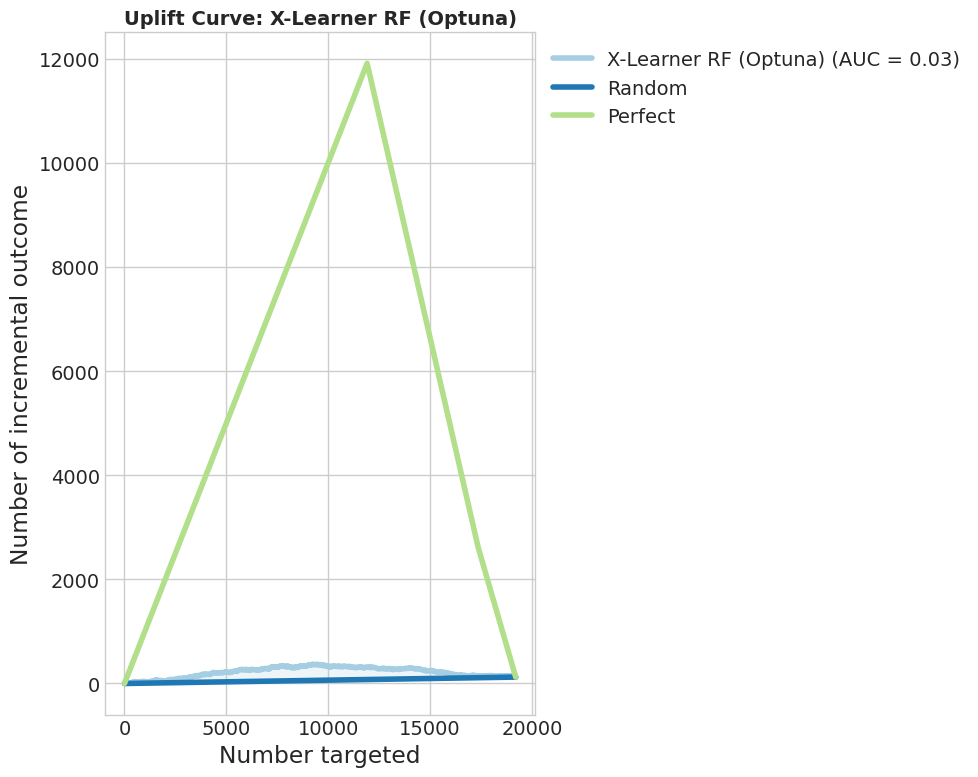

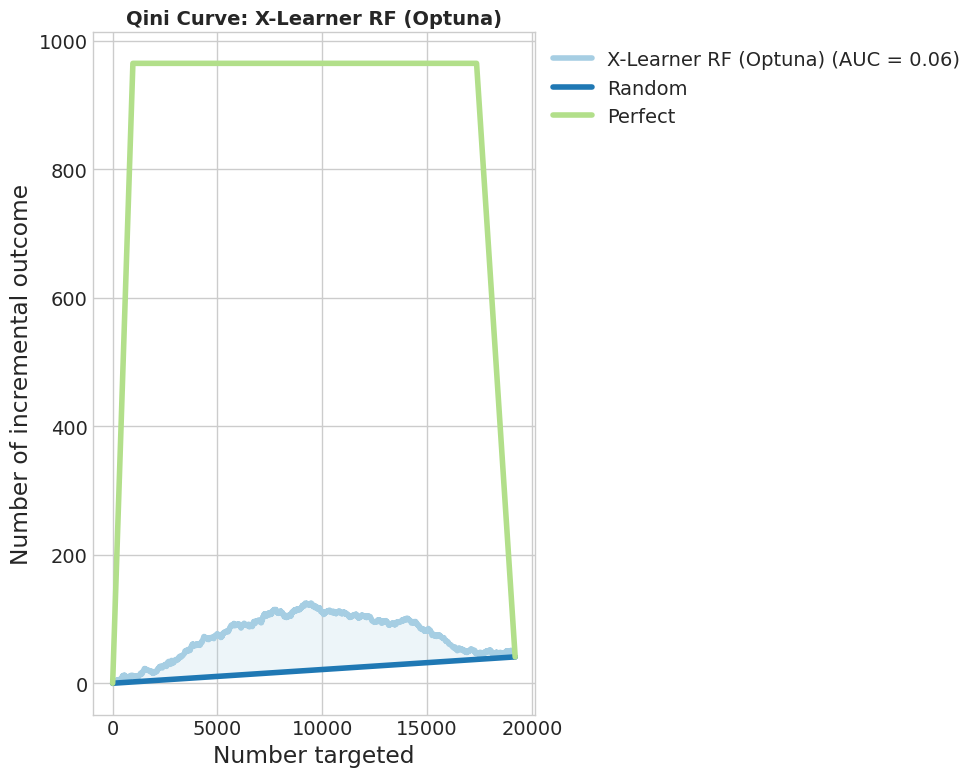

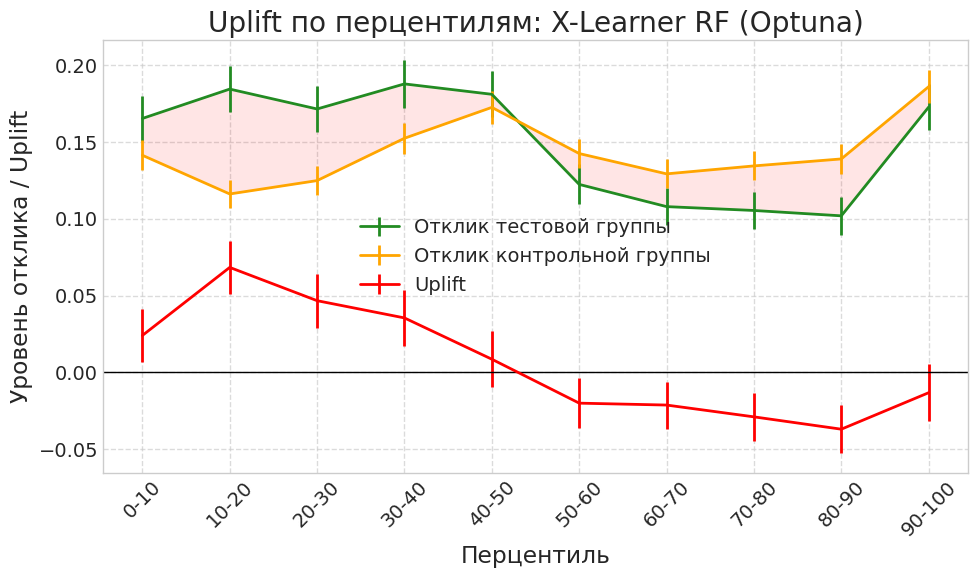

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

<Figure size 1200x600 with 0 Axes>

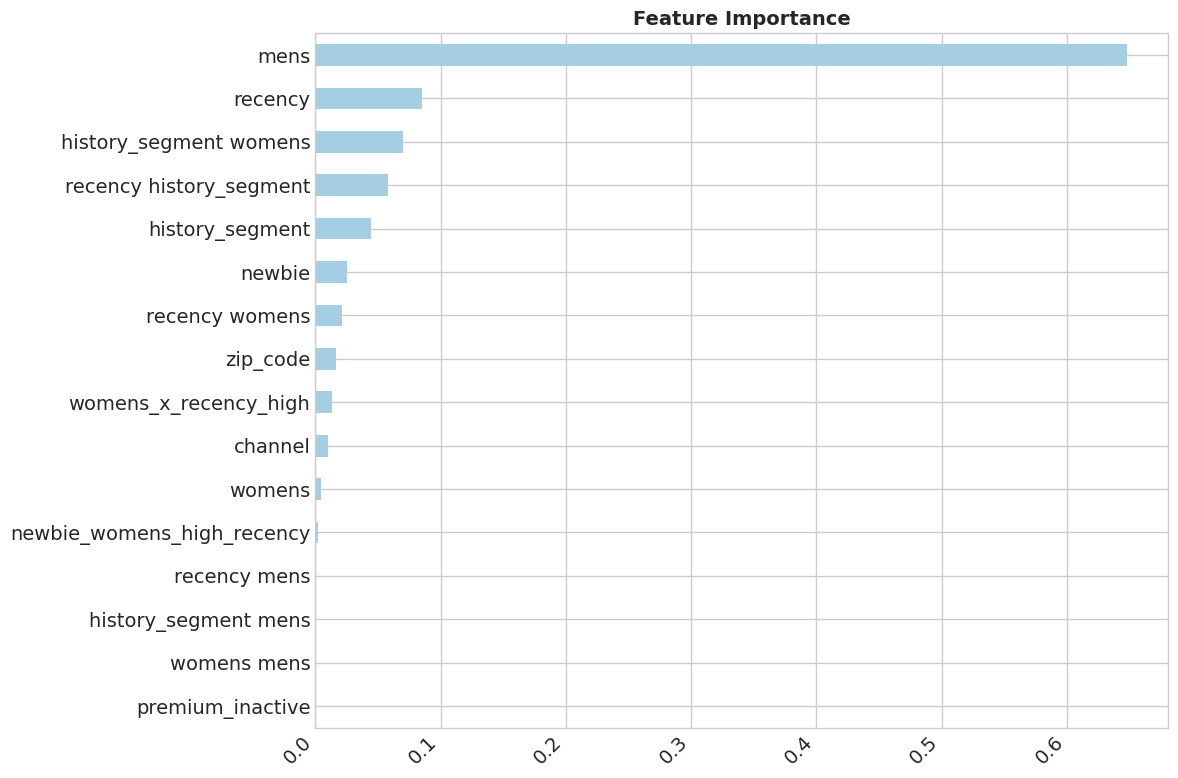

ВИЗУАЛИЗАЦИИ ЛУЧШЕЙ X-LEARNER МОДЕЛИ (OPTUNA)
Обучаем X-Learner с лучшими параметрами...
МЕТРИКИ ЛУЧШЕЙ МОДЕЛИ X-LEARNER (OPTUNA)
Uplift AUC:   0.0269
Qini AUC:     0.0606
Uplift@30%:   0.0464
Optuna best:  0.0464
Разница:      +0.0000


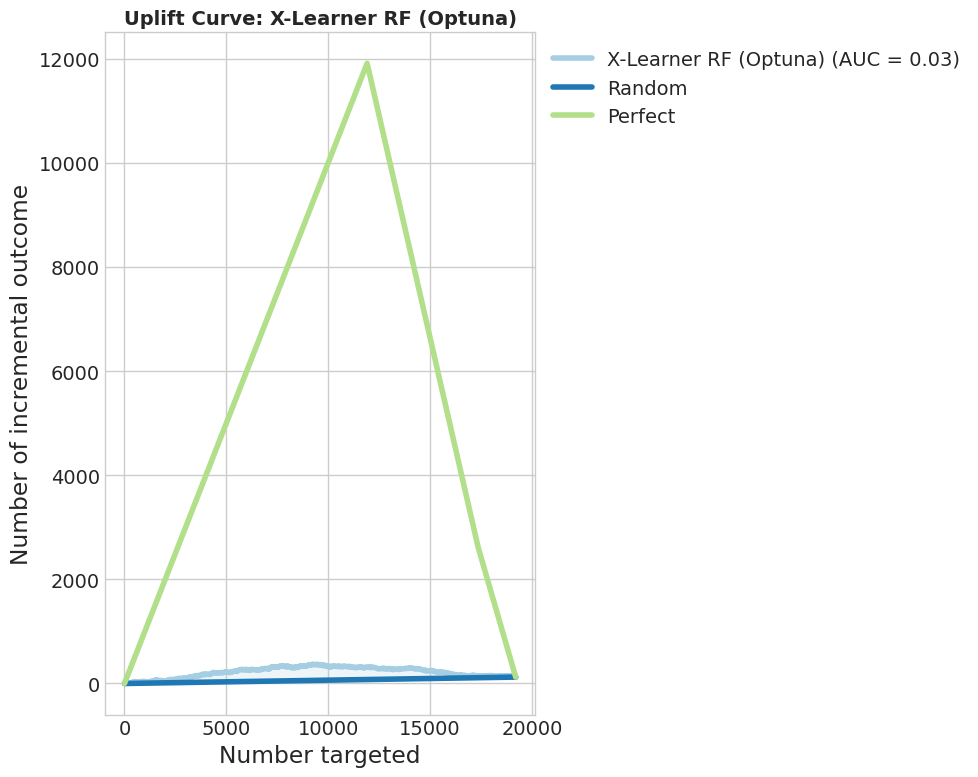

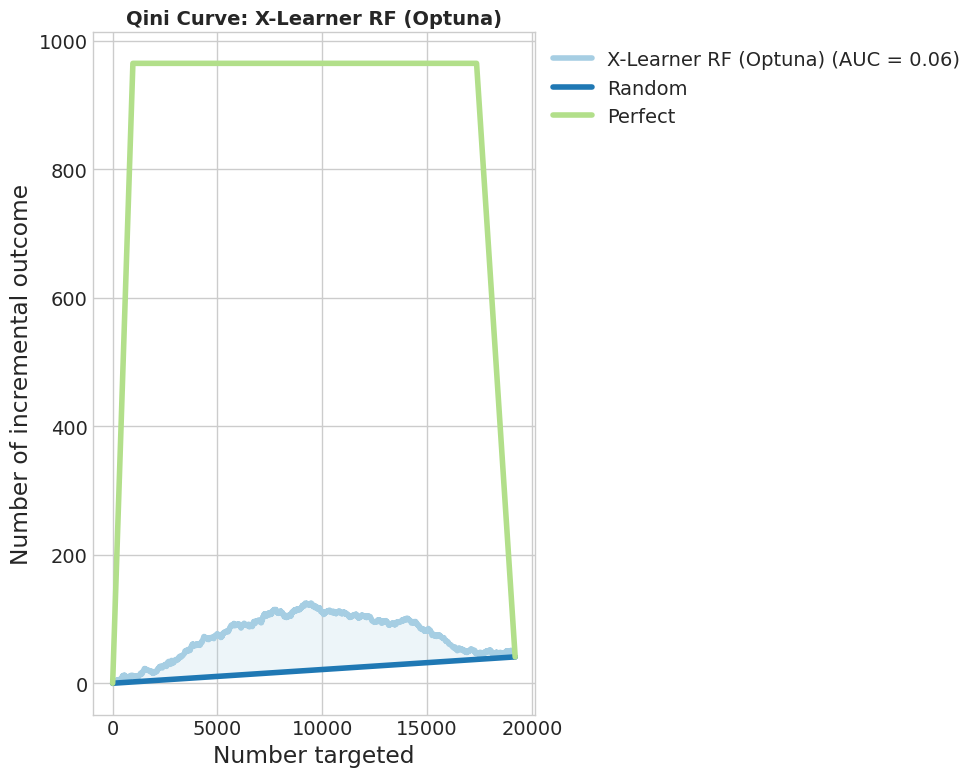

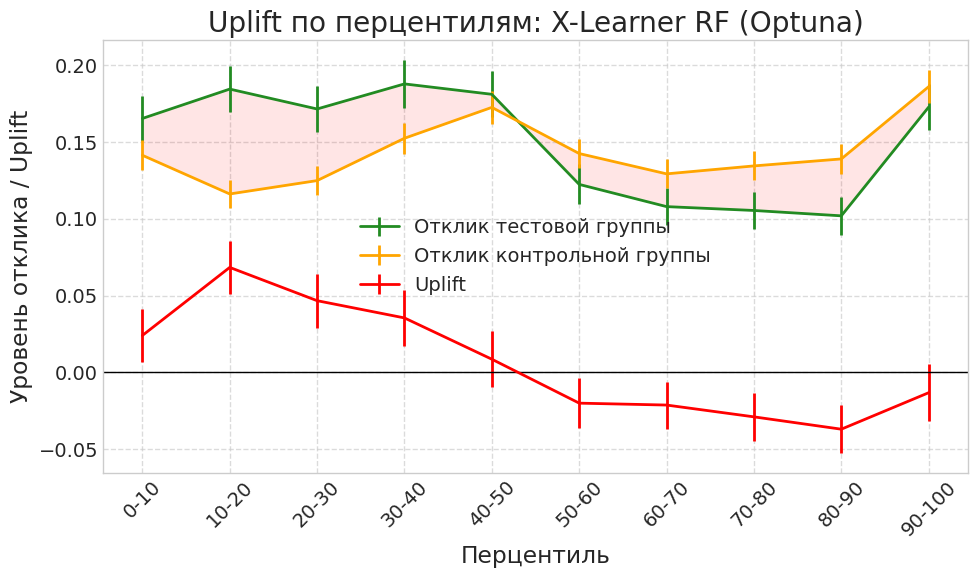

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

<Figure size 1200x600 with 0 Axes>

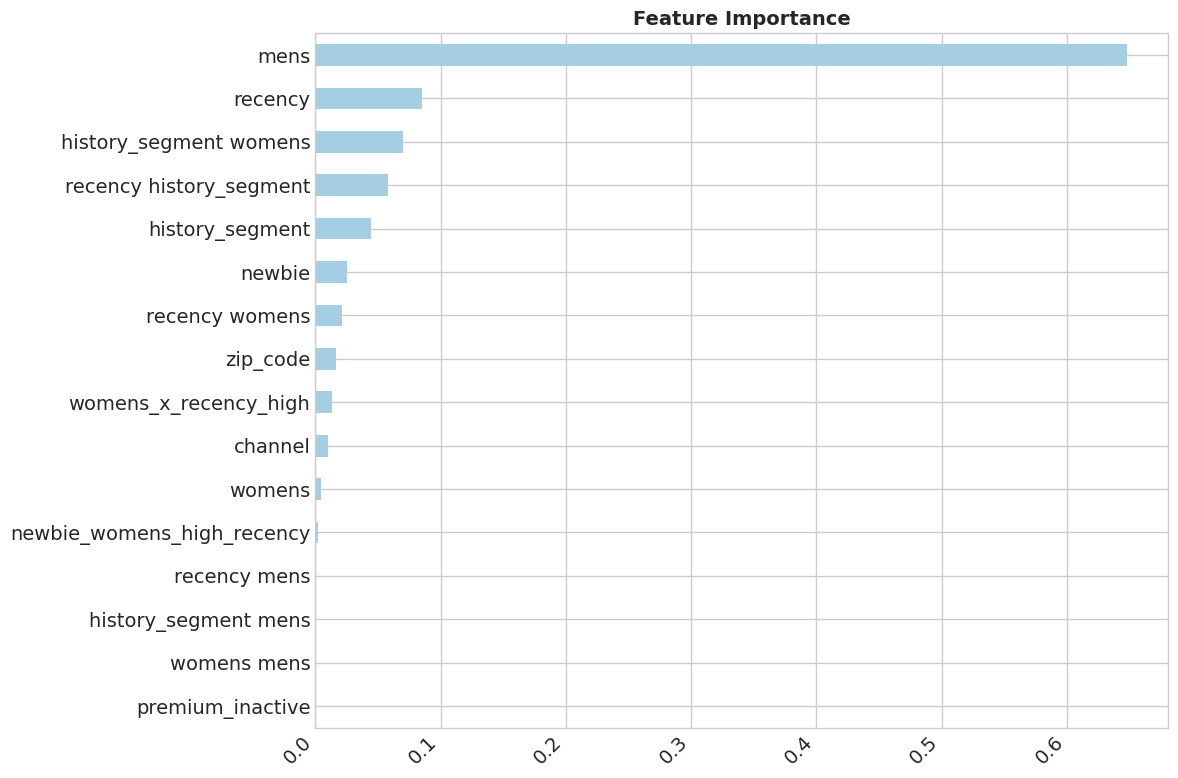

In [ ]:
#  ВИЗУАЛИЗАЦИЯ ЛУЧШЕЙ X-LEARNER МОДЕЛИ (OPTUNA)

print("ВИЗУАЛИЗАЦИИ ЛУЧШЕЙ X-LEARNER МОДЕЛИ (OPTUNA)")


# Обучаем с лучшими параметрами 
best_x_optuna = BaseXClassifier(
    outcome_learner=RandomForestClassifier(
        **study.best_params, 
        random_state=42, 
        n_jobs=-1, 
        verbose=0
    ),
    effect_learner=RandomForestRegressor(
        **study.best_params, 
        random_state=42, 
        n_jobs=-1, 
        verbose=0
    ),
    control_name='control'
)

print("Обучаем X-Learner с лучшими параметрами...")

# ИСПОЛЬЗУЕМ X_train_full и X_test_full
best_x_optuna.fit(
    X=X_train_full.copy(),
    treatment=treatment_train_mapped.values,
    y=y_train.values
)

# Предсказания
X_test_copy = X_test_full.copy()
X_test_copy.flags.writeable = True
uplift_pred_best = best_x_optuna.predict(X=X_test_copy).squeeze()

#  МЕТРИКИ 
uplift_auc_best = uplift_auc_score(y_test.values, uplift_pred_best, treatment_test.values)
qini_auc_best = qini_auc_score(y_test.values, uplift_pred_best, treatment_test.values)
uplift_30_best = uplift_at_k(y_test.values, uplift_pred_best, treatment_test.values, 
                             strategy='overall', k=0.3)


print("МЕТРИКИ ЛУЧШЕЙ МОДЕЛИ X-LEARNER (OPTUNA)")

print(f"Uplift AUC:   {uplift_auc_best:.4f}")
print(f"Qini AUC:     {qini_auc_best:.4f}")
print(f"Uplift@30%:   {uplift_30_best:.4f}")
print(f"Optuna best:  {study.best_value:.4f}")
print(f"Разница:      {uplift_30_best - study.best_value:+.4f}")


#  UPLIFT CURVE 
fig, ax = plt.subplots(figsize=(10, 8))
plot_uplift_curve(y_test.values, uplift_pred_best, treatment_test.values,
                  perfect=True, ax=ax, name="X-Learner RF (Optuna)")
plt.title('Uplift Curve: X-Learner RF (Optuna)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

#  QINI CURVE 
fig, ax = plt.subplots(figsize=(10, 8))
plot_qini_curve(y_test.values, uplift_pred_best, treatment_test.values,
                perfect=True, ax=ax, name="X-Learner RF (Optuna)")
plt.title('Qini Curve: X-Learner RF (Optuna)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

#  UPLIFT ПО ПЕРЦЕНТИЛЯМ 
fig = custom_uplift_by_percentile(
    y_true=y_test.values,
    uplift=uplift_pred_best,
    treatment=treatment_test.values,
    kind='line',
    bins=10,
    title='Uplift по перцентилям: X-Learner RF (Optuna)'
)
plt.show()


other_features = [col for col in X_train.columns if col not in important_features]


poly_feature_names = poly.get_feature_names_out(important_features) 

all_feature_names = other_features + list(poly_feature_names)

# Feature Importance с реальными названиями
plt.figure(figsize=(12, 6))
best_x.plot_importance(
    X=X_test_full.copy(), 
    tau=uplift, 
    features=all_feature_names
)
plt.title('Feature Importance', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
# Случайная перестановка treatment
T_random = np.random.permutation(treatment_test.values)

uplift_auc_random = uplift_auc_score(y_test.values, uplift, T_random)

print(f"Uplift AUC после случайного T: {uplift_auc_random:.4f}")



Uplift AUC после случайного T: 0.0022


Зарегистрируем модель.

In [128]:
# Устанавливаем MLflow tracking-сервер
mlflow.set_tracking_uri("http://0.0.0.0:5000")
mlflow.set_experiment("Uplift_Models")

model_name = "X_learner_RF"

with mlflow.start_run(run_name=model_name) as run:
    # Логируем параметры Optuna
    mlflow.log_params(study.best_params)

    # Обучаем модель
    best_x_optuna = BaseXClassifier(
        outcome_learner=RandomForestClassifier(
            **study.best_params, random_state=42, n_jobs=-1, verbose=0
        ),
        effect_learner=RandomForestRegressor(
            **study.best_params, random_state=42, n_jobs=-1, verbose=0
        ),
        control_name='control'
    )

    best_x_optuna.fit(X_train_full.copy(), treatment_train_mapped.values, y_train.values)
    uplift_pred = best_x_optuna.predict(X_test_full.copy()).squeeze()

    # Метрики
    uplift_auc = uplift_auc_score(y_test.values, uplift_pred, treatment_test.values)
    qini_auc = qini_auc_score(y_test.values, uplift_pred, treatment_test.values)
    uplift_30 = uplift_at_k(y_test.values, uplift_pred, treatment_test.values, strategy='overall', k=0.3)

    # Логируем метрики
    mlflow.log_metric("uplift_auc", uplift_auc)
    mlflow.log_metric("qini_auc", qini_auc)
    mlflow.log_metric("uplift_30", uplift_30)

    # Логируем модель (в run)
    model_uri = mlflow.sklearn.log_model(
        sk_model=best_x_optuna,
        artifact_path=model_name
    ).model_uri

    # Регистрируем модель в MLflow Model Registry
    registered_model = mlflow.register_model(
        model_uri=model_uri,
        name=model_name
    )

print(f"Модель '{model_name}' успешно зарегистрирована в MLflow Registry!")
print(f"Зарегистрированная версия: v{registered_model.version}")
print(f"Uplift AUC={uplift_auc:.4f} | Qini AUC={qini_auc:.4f} | Uplift@30%={uplift_30:.4f}")


2025/11/06 15:10:03 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/06 15:10:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'X_learner_RF'.
2025/11/06 15:10:08 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: X_learner_RF, version 1
Created version '1' of model 'X_learner_RF'.


🏃 View run X_learner_RF at: http://0.0.0.0:5000/#/experiments/44/runs/6b5bd02b726e416bbbcdb0f880bfcef4
🧪 View experiment at: http://0.0.0.0:5000/#/experiments/44
Модель 'X_learner_RF' успешно зарегистрирована в MLflow Registry!
Зарегистрированная версия: v1
Uplift AUC=0.0269 | Qini AUC=0.0606 | Uplift@30%=0.0464


Модель реально работает лучше случайного, Uplift AUC больше случайного аж почти в 12 раз.

Для некоторых сегментов (средние/нижние перцентили) модель не приносит положительного эффекта, но это относительно нормально для аплифт-моделей.

Uplift@30% показывает практическую ценность: если выбрать 30% пользователей с наибольшим предсказанным uplift, отклик повышается на 4.6%.

Максимальные метрики:

МЕТРИКИ ЛУЧШЕЙ МОДЕЛИ X-LEARNER (OPTUNA)
- Uplift AUC:   0.0223
- Qini AUC:     0.0513
- Uplift@30%:   0.0461

# Этап 3

In [75]:
all_feature_names

['zip_code',
 'newbie',
 'channel',
 'womens_x_recency_high',
 'premium_inactive',
 'newbie_womens_high_recency',
 'recency',
 'history_segment',
 'womens',
 'mens',
 'recency history_segment',
 'recency womens',
 'recency mens',
 'history_segment womens',
 'history_segment mens',
 'womens mens']

In [ ]:
class UpliftModelInference:
    """
    Класс для инференса uplift модели с учетом feature engineering.
    """
    def __init__(self, model, feature_names=None, logger=None):
        """
        Инициализация класса.

        Аргументы:
            model: Обученная модель uplift
            feature_names: Список базовых признаков для предсказания (опционально)
            logger: Объект для логирования (по умолчанию None)
        """
        self.model = model
        # Если feature_names не переданы, задаем базовые признаки по умолчанию
        self.base_feature_names = feature_names or ['recency', 'history_segment', 'history', 
                                                   'mens', 'womens', 'zip_code', 'newbie', 'channel']

        # Добавляем новые признаки для feature engineering
        self.engineered_features = ['womens_x_recency_high', 'premium_inactive', 'newbie_womens_high_recency']

        # Полиномиальные признаки создаются для следующих важных базовых признаков
        self.poly_features = ['recency', 'history_segment', 'womens', 'mens']

        # Генератор полиномиальных признаков для взаимодействий degree=2, interaction_only=True
        self.poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)

        self.logger = logger
        
        # Полный список всех признаков для проверки в predict
        # Учтем, что полиномиальные признаки расширяют poly_features
        # Полиномиальные признаки будут называться автоматически как "feature1 feature2"
        # Для проверки понадобится учитывать только базовые и вычисляемые признаки.
        # Для простоты проверяем базовые + фичи из feature engineering.
        
        if self.logger:
            self.logger.info("Модель UpliftModel инициализирована с базовыми признаками: %s", self.base_feature_names)
        
    def _transform_data(self, X: pd.DataFrame):
        X = X.copy()
        X['womens_x_recency_high'] = X['womens'] * (X['recency'] >= 7).astype(int)
        X['premium_inactive'] = ((X['history_segment'] >= 5) & (X['recency'] >= 6)).astype(int)
        X['newbie_womens_high_recency'] = X['newbie'] * X['womens'] * (X['recency'] >= 7).astype(int)

        X_poly = self.poly.fit_transform(X[self.poly_features])

        other_features = [col for col in X.columns if col not in self.poly_features and col != 'history']
        X_other = X[other_features].values

        X_transformed = np.hstack([X_other, X_poly])
        return X_transformed


    def predict(self, X: pd.DataFrame):
        """
        Получение предсказаний uplift.
        
        Аргументы:
            X: pandas.DataFrame с признаками для предсказания

        Возвращает:
            numpy.array с предсказанными значениями uplift или None для ошибочных случаев
        """
        # Проверка: пустой датафрейм
        if X.empty:
            if self.logger:
                self.logger.error("Предоставлен пустой датафрейм")
            return None

        # Проверка на пропущенные значения
        if X.isnull().any().any():
            if self.logger:
                self.logger.error("Входные данные содержат пропущенные значения")
            return [None] * len(X)

        if self.logger:
            self.logger.info("Выполняем предсказания для данных размерности %s", X.shape)

        # Проверка наличия базовых признаков, необходимых для feature engineering
        required_features = set(self.base_feature_names) - {'history'}  # history исключаем, т.к. её мы удаляем в примере
        missing_features = required_features - set(X.columns)
        if missing_features:
            error_msg = f"Отсутствуют признаки: {missing_features}"
            if self.logger:
                self.logger.error(error_msg)
            return [None] * len(X)

        if self.logger:
            self.logger.debug("Начинаем преобразование данных")
        X_transformed = self._transform_data(X)

        if self.logger:
            self.logger.debug("Выполняем предсказания модели")
        # Предсказание uplift модели (предполагается model с методом predict)
        uplift = self.model.predict(X_transformed)

        if self.logger:
            self.logger.info("Предсказания успешно завершены")

        return uplift


In [122]:
model = UpliftModelInference(model= best_x_optuna,
                             feature_names= ['recency', 'history_segment', 'history', 'mens', 'womens', 'zip_code', 'newbie', 'channel'])

In [123]:
test_data = pd.DataFrame({
            'recency': [1, 2, 3],
            'history_segment': [1, 2, 3], 
            'history': [100, 200, 300],
            'mens': [1, 0, 1],
            'womens': [0, 1, 0],
            'zip_code': [1, 0, 1],
            'newbie': [0, 1, 0],
            'channel': [1, 2, 0]
        })

In [124]:
# проверка работы класса
model.predict(test_data)

array([[-0.03520039],
       [-0.0016172 ],
       [-0.04314423]])

### Вывод

Для решения задачи была выбрана модель X-learner (так как присутствует гетерогенность в данных и дисбаланс классов) с моделями RandomForest (проявил себя лучше всех). Были сгенерирован несколько новых фичей на основе самых лучших признаков в соответсвии с анализом корреляций в данных.
Через Optuna были отобраны лучшие гиперпараметры. В целом, метрики вышли невысокие (но и в самих данных истинный аплифт тоже очень скромный, хотя статистическая значимоть между тестовой и контрольной группой имеется).

МЕТРИКИ ЛУЧШЕЙ МОДЕЛИ X-LEARNER:
- Uplift AUC:   0.0223
- Qini AUC:     0.0513
- Uplift@30%:   0.0461


Это в 12 раз лучше случайного предсказания и означает, что:

- Модель умеет выделять пользователей с повышенным откликом лучше случайного
- Среди топ-30% пользователей по предсказанному uplift реальный эффект ~4.6% выше, чем у контроля
- Для некоторых сегментов (средние/нижние перцентили по тратам) модель не приносит положительного эффекта, это нормально для аплифт-моделей — они концентрируются на тех, кто действительно реагирует на treatment.